In [32]:
import trenchripper as tr

import anndata
import urllib.request

import h5py
import copy
import warnings
import glob
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import skimage as sk
import colorcet as cc
import scanpy as sc
import matplotlib as mpl
import dask.dataframe as dd
from tslearn import metrics

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches

import goatools
import goatools.base
from goatools.base import download_go_basic_obo
from goatools.obo_parser import GODag
from goatools.anno.gaf_reader import GafReader

from dna_features_viewer import BiopythonTranslator
from Bio.SeqFeature import SeqFeature,FeatureLocation
from Bio import SeqIO

warnings.filterwarnings(action='once',category=UserWarning)

plt.style.use('./deaton.mplstyle')

### Load Functions

In [33]:
def get_higher_z(df):
    ## function to obtain the variant of maximum effect (for the nucleoid phenotype)
    df_mask = df["Feature Max Absolute Component"]==np.max(df["Feature Max Absolute Component"])
    df_out = df[df_mask]
    if np.sum(df_mask)>1:
        df_mask = df["Max Feature SEM"]==np.min(df["Max Feature SEM"])
        df_out = df_out[df_mask]
    return df_out

def assign_cluster(df,subcluster_level="Priority Subcluster"):
    ## function to assign variants to their modal cluster
    subcluster_series = df[subcluster_level]
    top_2_value_counts = subcluster_series.value_counts()[:2]
    if top_2_value_counts.iloc[0]==top_2_value_counts.iloc[1]:
        return (top_2_value_counts.index[0],top_2_value_counts.index[1])
    else:
        return (top_2_value_counts.index[0],top_2_value_counts.index[0])

def search_go(ns2assoc, obodag, inv_gene_to_id, go_term):
    namespace_abbv = {"biological_process":"BP","molecular_function":"MF","cellular_component":"CC"}
    
    print("Searching for " + str(obodag[go_term].name))
    namespace = namespace_abbv[obodag[go_term].namespace]
    child_goterms = list(obodag[go_term].get_all_children())
    gene_list = [inv_gene_to_id[key] for key,val in ns2assoc[namespace].items() if go_term in val]
    for child_goterm in child_goterms:    
        gene_list += [inv_gene_to_id[key] for key,val in ns2assoc[namespace].items() if child_goterm in val]
    gene_list = sorted(list(set(gene_list)))
    return gene_list

def lookup_variant(variant_library_path,channel,varid,trench_indices):
    path_prefix = variant_library_path + "/" + str(varid) + "_"
    variant_files = glob.glob(path_prefix + '*')
    n_files = len(variant_files)
    img_arr = []
    for i in range(n_files):
        variant_file = path_prefix + str(i) + ".hdf5"
        with h5py.File(variant_file,"r") as infile:
            data = infile[channel][trench_indices]
            img_arr.append(data)
    img_arr = np.concatenate(img_arr,axis=1)
    return img_arr

def get_magenta_green_overlay(green_arr,mag_arr,green_arr_min,green_arr_max,mag_arr_min,\
                              mag_arr_max,mag_weight=1.,green_weight=1.):
    
    # Expand dimensions to make them 3D arrays
    image1 = np.expand_dims(green_arr, axis=-1)
    image2 = np.expand_dims(mag_arr, axis=-1)
    
    # Make image1 green
    img_green = np.zeros((image1.shape[0], image1.shape[1], 3), dtype=np.uint16)
    img_green[:, :, 1] = image1[:,:,0]
    
    # Make image2 magenta
    img_magenta = np.zeros((image2.shape[0], image2.shape[1], 3), dtype=np.uint16)
    img_magenta[:, :, 0] = image2[:,:,0]
    img_magenta[:, :, 2] = image2[:,:,0]
    
    # # Apply contrast to the green channel
    img_green[:, :, 1] = sk.exposure.rescale_intensity(np.clip(img_green[:, :, 1],green_arr_min,green_arr_max)).astype('uint16')
    
    # Apply contrast to the magenta channel
    img_magenta[:, :, 0] = sk.exposure.rescale_intensity(np.clip(img_magenta[:, :, 0],mag_arr_min,mag_arr_max)).astype('uint16')
    img_magenta[:, :, 2] = sk.exposure.rescale_intensity(np.clip(img_magenta[:, :, 2],mag_arr_min,mag_arr_max)).astype('uint16')
    
    merged_image = ((img_green*green_weight)+(img_magenta*mag_weight)).astype('uint16')
    return merged_image

### Load Data

In [34]:
expt_data_rootpath = "/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/lDE20_Imaging/Clustering"
clustering_df = pd.read_pickle(expt_data_rootpath + "/Pandas_Dataframe.pkl")
clustering_an_df = anndata.read_h5ad(expt_data_rootpath + "/AnnData_wSteadyState.h5ad")
an_df_clustree = anndata.read_h5ad(expt_data_rootpath+"/AnnData_nonRcompat.h5ad")
control_phenotypes_df = pd.read_pickle(expt_data_rootpath + "/2023-01-23_sgRNA_Timeseries_df.pkl")
control_phenotypes_df = control_phenotypes_df[control_phenotypes_df["Category"].isin(['OnlyPlasmid', 'NoTarget'])].copy()

clustering_an_df.obs.index = clustering_an_df.obs.index.astype(int)

## add final values
kernel_label_list = ['Kernel Trace: Delta time (s)','Kernel Trace: Septum Displacement Length Normalized','Kernel Trace: Length',\
'Kernel Trace: Width','Kernel Trace: mCherry mean_intensity','Kernel Trace: Instantaneous Growth Rate: Volume']
for kernel_label in kernel_label_list:
    clustering_df["8 Hours: " + kernel_label] = clustering_df[kernel_label].apply(lambda x: x[19])

clustering_df['8 Hours: Kernel Trace: Delta time (hr)'] = clustering_df['8 Hours: Kernel Trace: Delta time (s)']/3600
clustering_df['8 Hours: Kernel Trace: Instantaneous Growth Rate: Volume'] = clustering_df['8 Hours: Kernel Trace: Instantaneous Growth Rate: Volume']/np.log(2)

## load controls
## add final values
kernel_label_list = ['Kernel Trace: Delta time (s)','Kernel Trace: Septum Displacement Length Normalized','Kernel Trace: Length',\
'Kernel Trace: Width','Kernel Trace: mCherry mean_intensity','Kernel Trace: Instantaneous Growth Rate: Volume']
for kernel_label in kernel_label_list:
    control_phenotypes_df["8 Hours: " + kernel_label] = control_phenotypes_df[kernel_label].apply(lambda x: x[19])
control_phenotypes_df['8 Hours: Kernel Trace: Delta time (hr)'] = control_phenotypes_df['8 Hours: Kernel Trace: Delta time (s)']/3600
control_phenotypes_df['8 Hours: Kernel Trace: Instantaneous Growth Rate: Volume'] = control_phenotypes_df['8 Hours: Kernel Trace: Instantaneous Growth Rate: Volume']/np.log(2)

cluster_levels = ["L0","L1","L2","L3"]
cluster_resolutions = [0.2,0.5,1.0,2.0]

umap_fig_df = clustering_an_df.obs.copy()[cluster_levels]
umap_fig_df["X Coord"] = clustering_an_df.obsm['X_umap'][:,0]
umap_fig_df["Y Coord"] = clustering_an_df.obsm['X_umap'][:,1]
umap_fig_df.index = umap_fig_df.index.astype(int)
umap_fig_df = umap_fig_df.join(clustering_df.drop(columns=cluster_levels),on="oDEPool7_id")

for cluster_level in cluster_levels:
    all_clusters = list(umap_fig_df[cluster_level].unique())
    colors = cc.glasbey_hv[:len(all_clusters)]
    # Create a dictionary mapping each category to a color
    reorder_cluster_dict = {cluster:i for i,cluster in enumerate(all_clusters)}
    color_dict = dict(zip(all_clusters, colors))
    umap_fig_df[cluster_level + " Color"] = umap_fig_df[cluster_level].astype(str).apply(lambda x: color_dict[x])

/home/de64/micromamba/envs/crispri/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


#### Appending Nucleoid Observations (from lDE26)

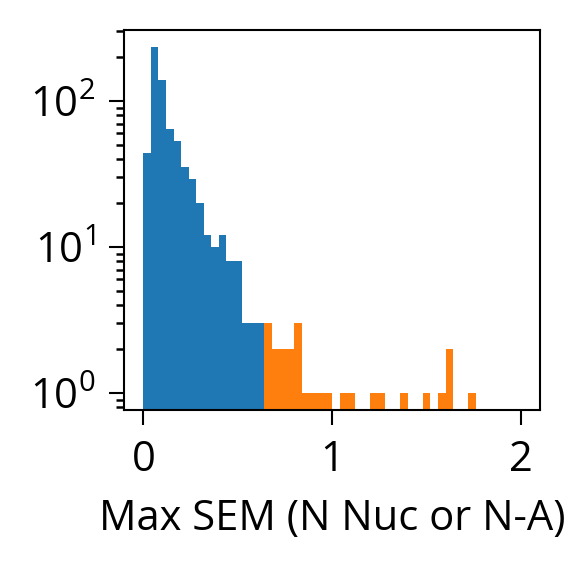

In [35]:
## updated, see previous if it doesn't work
plt.figure(figsize=(2,2))
nuc_sem_thr = 0.65
nucleoid_z_score_list = ['Kernel Trace: Total Nucleoid Area per Cell Area: Transformed: z score',\
                         'Kernel Trace: Number of Nucleoids: Transformed: z score']

nucleoid_df = pd.read_pickle('/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/lDE26_Imaging/2023-04-25_sgRNA_Timeseries_df.pkl')
for i, label in enumerate(nucleoid_z_score_list):
    nucleoid_df = nucleoid_df.copy()
    nucleoid_df[label + ": Max Absolute Z-score"] = nucleoid_df[label].apply(lambda x: np.max(np.abs(x)))
nucleoid_df["Feature Max Absolute Component"] = nucleoid_df[[label + ": Max Absolute Z-score" for label in nucleoid_z_score_list]].apply(lambda x: np.max(x), axis=1)
nucleoid_df["Max Feature SEM"] = nucleoid_df[["SEM: " + label for label in nucleoid_z_score_list]].apply(lambda x: np.max(np.array(x.values.tolist())), axis=1)

control_nucleoid_df = nucleoid_df[nucleoid_df["Category"].isin(['NoTarget'])]

plt.hist(nucleoid_df[nucleoid_df["Max Feature SEM"]<nuc_sem_thr]["Max Feature SEM"],bins=50,range=(0,2),log=True)
plt.hist(nucleoid_df[nucleoid_df["Max Feature SEM"]>nuc_sem_thr]["Max Feature SEM"],bins=50,range=(0,2),log=True)
plt.xlabel("Max SEM (N Nuc or N-A)")
plt.show()

In [36]:
single_gene_nucleoid_df = nucleoid_df.groupby("Gene").apply(lambda x: get_higher_z(x))
single_gene_nucleoid_df = single_gene_nucleoid_df.droplevel(0).sort_index()
gene_NA_df = single_gene_nucleoid_df.set_index("Gene").sort_index()[["Kernel Trace: Total Nucleoid Area per Cell Area",\
                                                    "Kernel Trace: Number of Nucleoids"]]
clustering_df = clustering_df.reset_index().set_index("Gene").join(gene_NA_df).reset_index().set_index("oDEPool7_id")
len_nuc_timeseries = len(nucleoid_df["Kernel Trace: Total Nucleoid Area per Cell Area"].iloc[0])
clustering_df["Kernel Trace: Total Nucleoid Area per Cell Area"] = \
                    clustering_df["Kernel Trace: Total Nucleoid Area per Cell Area"].apply(lambda x:\
                    [np.NaN for i in range(len_nuc_timeseries)] if np.all(np.isnan(x)) else x)
clustering_df["Kernel Trace: Number of Nucleoids"] = \
                clustering_df["Kernel Trace: Number of Nucleoids"].apply(lambda x:\
                [np.NaN for i in range(len_nuc_timeseries)] if np.all(np.isnan(x)) else x)
kernel_label_list = ['Kernel Trace: Total Nucleoid Area per Cell Area','Kernel Trace: Number of Nucleoids']

for kernel_label in kernel_label_list:
    clustering_df["8 Hours: " + kernel_label] = clustering_df[kernel_label].apply(lambda x: x[19])
    control_nucleoid_df["8 Hours: " + kernel_label] = control_nucleoid_df[kernel_label].apply(lambda x: x[19])

clusters_df = clustering_df.dropna(subset=["L0"])

/tmp/ipykernel_35359/1008513914.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  single_gene_nucleoid_df = nucleoid_df.groupby("Gene").apply(lambda x: get_higher_z(x))
/tmp/ipykernel_35359/1008513914.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  control_nucleoid_df["8 Hours: " + kernel_label] = control_nucleoid_df[kernel_label].apply(lambda x: x[19])
/tmp/ipykernel_35359/1008513914.py:17: SettingWithCopyWarning: 
A value is trying to be set on a c

#### Setting Scale Ranges

In [37]:
cbar_ticks_list = [[0.,0.7,1.4],[0.,0.03,0.06],[2,4,6],\
              [1.2,1.25,1.3],[0,2500,5000],[0,0.8,1.6],\
              [0.5,0.55,0.6],[1.2,1.7,2.2]]

cbar_label = ""
labels = ['8 Hours: Kernel Trace: Delta time (hr)','8 Hours: Kernel Trace: Septum Displacement Length Normalized',\
          '8 Hours: Kernel Trace: Length','8 Hours: Kernel Trace: Width',\
          '8 Hours: Kernel Trace: mCherry mean_intensity','8 Hours: Kernel Trace: Instantaneous Growth Rate: Volume']
label_names = [r'$ \tau $',r'$ L_{S} $',r'$ L $',r'$ W $',r'$ I_{rpsL} $',r'$ \lambda $','NC',r'$N_{n}$']
nuc_labels = ['8 Hours: Kernel Trace: Total Nucleoid Area per Cell Area','8 Hours: Kernel Trace: Number of Nucleoids']
all_labels = labels + nuc_labels
label_percentiles = [7,0.5,7,7,7,7,7,7]

title_list = ["Interdivision Time (hr)","Septum Error","Length $(\mu m)$","Width $(\mu m)$",\
              "mKate2 Mean Intensity (AU)","Growth Rate (1/hr)","NC Ratio","N Nucleoids"]

median_vals_dict = {**control_phenotypes_df[labels].median().to_dict(),**control_nucleoid_df[nuc_labels].median().to_dict()}
median_properties = clusters_df.groupby("L3")[all_labels].median()

min_vals = []
max_vals = []
for i,label in enumerate(all_labels):
    vmin,vmax = np.nanpercentile(clusters_df[label],label_percentiles[i]),np.nanpercentile(clusters_df[label],100-label_percentiles[i])
    vcenter = median_vals_dict[label]
    min_deviation,max_deviation = (vcenter-vmin,vmax-vcenter)
    if min_deviation>max_deviation:
        vmax = vcenter + min_deviation
    else:
        vmin = vcenter - max_deviation
    min_vals.append(vmin)
    max_vals.append(vmax)

/tmp/ipykernel_35359/224861063.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_properties = clusters_df.groupby("L3")[all_labels].median()


#### Loading GO Information

In [38]:
# Get ontologies
obo_fname = download_go_basic_obo()

# Get ecoli association file (ecocyc)
gaf_handle = goatools.base.http_get("http://current.geneontology.org/annotations/ecocyc.gaf.gz",fout="./ecocyc.gaf.gz")
gaf_fname = goatools.base.gunzip("./ecocyc.gaf.gz")

## Getting ontologies and other nonesense

obodag = GODag(obo_fname)
objanno = GafReader(gaf_fname)
ns2assoc = objanno.get_ns2assc()

gene_to_id = {assoc.DB_Symbol:assoc.DB_ID for assoc in objanno.associations}
inv_gene_to_id = {assoc.DB_ID:assoc.DB_Symbol for assoc in objanno.associations}
synonym_dict = {synonym:assoc.DB_ID for assoc in objanno.associations for synonym in assoc.DB_Synonym}
gene_to_id.update(synonym_dict)

  EXISTS: go-basic.obo
requests.get(http://current.geneontology.org/annotations/ecocyc.gaf.gz, stream=True)
  WROTE: ./ecocyc.gaf.gz

go-basic.obo: fmt(1.2) rel(2024-10-27) 44,017 Terms
HMS:0:00:00.349490  58,540 annotations READ: ./ecocyc.gaf 


#### Setting Up Selected Clusters and Cmaps

In [39]:
n_gene_counts_min = 2
min_representatives = 5
cluster_level = "L3"
## this will also be the priority order of clusters (higher priority clusters on the right)
subcluster_levels = ["L3"]

## filamentous clusters
filament_selected_clusters =  ["20","21","26","29","37","45","50"]
filament_highlighted_subclusters = [("L3","20"),("L3","21"),("L3","26"),("L3","29"),\
                                    ("L3","37"),("L3","50"),("L3","45")]
# ("L3","35")

# ## wide clusters
wide_selected_clusters = ["0","6","28","39"]
wide_highlighted_subclusters = [("L3","0"),("L3","6"),("L3","28"),("L3","39")]

# ## thin clusters
thin_selected_clusters = ["34","41"]
thin_highlighted_subclusters = [("L3","34"),("L3","41")]

## get unhighlighted filamentous subclusters
filament_cluster_df = clusters_df[clusters_df[cluster_level].isin(filament_selected_clusters)].copy()
filament_unhighlighted_subclusters = []
for subcluster_level in subcluster_levels:
    clusters,n_rep_clusters = np.unique(filament_cluster_df[subcluster_level],return_counts=True)
    subclusters = clusters[n_rep_clusters>=min_representatives]
    filament_highlighted_subclusters_working_level = [item[1] for item in filament_highlighted_subclusters if item[0]==subcluster_level]
    filament_unhighlighted_subclusters_working_level = sorted(list(set(subclusters)-set(filament_highlighted_subclusters_working_level)))
    filament_unhighlighted_subclusters_working_level = [(subcluster_level,item) for item in filament_unhighlighted_subclusters_working_level]
    filament_unhighlighted_subclusters += filament_unhighlighted_subclusters_working_level

# ## get unhighlighted wide subclusters
wide_cluster_df = clusters_df[clusters_df[cluster_level].isin(wide_selected_clusters)].copy()
wide_unhighlighted_subclusters = []
for subcluster_level in subcluster_levels:
    clusters,n_rep_clusters = np.unique(wide_cluster_df[subcluster_level],return_counts=True)
    subclusters = clusters[n_rep_clusters>=min_representatives]
    wide_highlighted_subclusters_working_level = [item[1] for item in wide_highlighted_subclusters if item[0]==subcluster_level]
    wide_unhighlighted_subclusters_working_level = sorted(list(set(subclusters)-set(wide_highlighted_subclusters_working_level)))
    wide_unhighlighted_subclusters_working_level = [(subcluster_level,item) for item in wide_unhighlighted_subclusters_working_level]
    wide_unhighlighted_subclusters += wide_unhighlighted_subclusters_working_level
# ## get unhighlighted thin subclusters
thin_cluster_df = clusters_df[clusters_df[cluster_level].isin(thin_selected_clusters)].copy()
thin_unhighlighted_subclusters = []
for subcluster_level in subcluster_levels:
    clusters,n_rep_clusters = np.unique(thin_cluster_df[subcluster_level],return_counts=True)
    subclusters = clusters[n_rep_clusters>=min_representatives]
    thin_highlighted_subclusters_working_level = [item[1] for item in thin_highlighted_subclusters if item[0]==subcluster_level]
    thin_unhighlighted_subclusters_working_level = sorted(list(set(subclusters)-set(thin_highlighted_subclusters_working_level)))
    thin_unhighlighted_subclusters_working_level = [(subcluster_level,item) for item in thin_unhighlighted_subclusters_working_level]
    thin_unhighlighted_subclusters += thin_unhighlighted_subclusters_working_level

## all clusters
all_selected_clusters = filament_selected_clusters + wide_selected_clusters + thin_selected_clusters
all_highlighted_subclusters = filament_highlighted_subclusters + wide_highlighted_subclusters + thin_highlighted_subclusters
all_unhighlighted_subclusters = filament_unhighlighted_subclusters + wide_unhighlighted_subclusters + thin_unhighlighted_subclusters
all_unhighlighted_subclusters = sorted(list(set(all_unhighlighted_subclusters) - set(all_highlighted_subclusters)))

#### Annotating Operons and Off Targets
- Operons and off target effects based on individual inspection of ecocyc annotation

In [40]:
dcw_operon_dict = {"O1-murC": ["mraZ","rsmH","ftsL","ftsI","murE","murF","mraY","murD","ftsW","murG","murC"],\
                  "O1-ftsA": ["ddlB","ftsQ","ftsA","ftsZ"],\
                  "O1-lpxC": ["lpxC"]}
nrd_operon_dict = {"O2-nrdB": ["ypaB", "nrdA", "nrdB"]}
dnaA_gyrB_operon_dict = {"O3-gyrB": ["gyrB"],\
                  "O3-dnaN": ["recF","dnaN"],\
                  "O3-dnaA": ["dnaA"]}
leuS_cobC_operon_dict = {"O4-holA": ["lptE", "holA"],\
                  "O4-leuS": ["leuS"]}
pabC_ycfH_operon_dict = {"O5-tmk": ["pabC","mltG","tmk"],\
                        "O5-holB": ["holB", "ycfH"]}
secE_nusG_operon_dict = {"O6-nusG": ["secE","nusG"]}
rpoBC_operon_dict = {"O7-rpoC": ["rpoB","rpoC"]}
rho_operon_dict = {"O8-rho": ["rhoL","rho"]}
muk_operon_dict = {"O9-mukB":["mukF","mukE","mukB"]}
folP_glmM_operon_dict = {"O10-folP":["folP"],\
                       "O10-glmM":["glmM"]}
dnaTC_operon_dict = {"O11-dnaC":["dnaT","dnaC"]}
lpxD_dnaE_operon_dict = {"O12-lpxD": ["skp", "lpxD"],\
                        "O12-fabZ": ["fabZ"],\
                         "O12-lpxA": ["lpxA"],\
                          "O12-lpxB": ["lpxB"]}
dxr_rseP_operon_dict = {"O13-dxr":["pyrH","frr","dxr"]}
rsfS_rlpA_operon_dict = {"O14-mrdB":["rsfS","rlmH","mrdA","mrdB","rlpA"]}
mre_operon_dict = {"O15-mreD":["mreB","mreC","mreD"]}
glmUS_operon_dict = {"O16-glmS":["glmU","glmS"]}
lolCDE_operon_dict = {"O17-lolE":["lolC","lolD","lolE"]}
yejLM_operon_dict = {"O18-yejM":["yejL","yejM"]}
ybeX_lnt_operon_dict = {"O19-lnt":["ybeZ","ybeY","ybeX","lnt"]}
yrbG_lptB_operon_dict = {"O20-lptA":["kdsD","kdsC","lptC","lptA"]}
lptFG_operon_dict = {"O21-lptG":["lptF","lptG"]}
lspA_ispH_operon_dict = {"O22-lspA":["lspA"],\
                        "O22-ispH":["fkpB","ispH"]}
ibaG_murA_operon_dict = {"O23-murA":["ibaG","murA"]}
lgt_thyA_operon_dict = {"O24-lgt":["lgt"],\
                       "O24-thyA":["thyA"]}
ppiB_lpxH_operon_dict = {"O25-lpxH":["ppiB","lpxH"]}
rfaD_waaL_operon_dict = {"O26-waaC":["rfaD","waaF","waaC","waaL"]}
secM_secA_operon_dict = {"O27-secA":["secM","secA"]}

inv_operon_dict = {**dcw_operon_dict,**nrd_operon_dict,**lpxD_dnaE_operon_dict,**dnaA_gyrB_operon_dict,**leuS_cobC_operon_dict,**pabC_ycfH_operon_dict,\
                  **secE_nusG_operon_dict,**rpoBC_operon_dict,**rho_operon_dict,**muk_operon_dict,**dxr_rseP_operon_dict,**folP_glmM_operon_dict,\
                  **rsfS_rlpA_operon_dict,**mre_operon_dict,**glmUS_operon_dict,**lolCDE_operon_dict,**yejLM_operon_dict,**ybeX_lnt_operon_dict,\
                  **yrbG_lptB_operon_dict,**lptFG_operon_dict,**rfaD_waaL_operon_dict,**dnaTC_operon_dict,**lspA_ispH_operon_dict,\
                  **ibaG_murA_operon_dict,**lgt_thyA_operon_dict,**ppiB_lpxH_operon_dict,**secM_secA_operon_dict}
operon_dict = {val:key for key,val_list in inv_operon_dict.items() for val in val_list}

off_target_non_polar = {("L3","0"):["ais","clpB","mlaF","yebT","yddG","yghJ"],\
                        ("L3","6"):["ais","oppB","mnmC","ispU"],\
                        ("L3","20"):["bcp","glrK","sbmA","ynfL"],\
                        ("L3","21"):["bisC","comR","pfkA"],\
                        ("L3","26"):[],\
                        ("L3","28"):["yjjV"],\
                        ("L3","29"):["fixX","kefB"],\
                        ("L3","34"):["ispU"],\
                        # ("L3","35"):["glrK"],\
                        ("L3","37"):[],\
                        ("L3","39"):["gltB","yihW"],\
                        ("L3","41"):[],\
                        # ("L3","42"):[],\
                        ("L3","45"):["rnb","yghJ"],\
                        ("L3","50"):["pyrC"]}

In [41]:
grey_rgb = (0.8,0.8,0.8)

all_l3_clusters = list(umap_fig_df["L3"].unique())
all_l3_clusters = [("L3",cluster) for cluster in all_l3_clusters]
## alt code to test
non_selected_clusters = list(set(all_l3_clusters)-set(all_highlighted_subclusters))

glasbey_hv_nogrey = cc.glasbey_hv[:100]
glasbey_hv_nogrey = [color for color in glasbey_hv_nogrey if (color[0]!=color[1]) or (color[1]!=color[2]) or (color[0]!=color[2])]

colors = glasbey_hv_nogrey[:len(all_highlighted_subclusters)]
non_selected_colors = glasbey_hv_nogrey[len(all_highlighted_subclusters):len(all_l3_clusters)]

# Create a dictionary mapping each category to a color
reorder_cluster_dict = {cluster:i for i,cluster in enumerate(all_highlighted_subclusters)}
color_dict = dict(zip(all_highlighted_subclusters, colors))
non_selected_color_dict = dict(zip(all_highlighted_subclusters+non_selected_clusters, colors+non_selected_colors))
for subcluster in all_unhighlighted_subclusters:
    color_dict[subcluster] = [0.8, 0.8, 0.8]
categorical_colors = [color_dict[item] for item in all_highlighted_subclusters]
all_categorical_colors = [non_selected_color_dict[item] for item in all_l3_clusters]
cluster_cmap = sns.color_palette(colors)
all_cluster_cmap = sns.color_palette(colors+non_selected_colors)
# normalize the data
cluster_norm = mpl.colors.Normalize(vmin=0, vmax=len(colors)-1)
all_cluster_norm = mpl.colors.Normalize(vmin=0, vmax=len(colors+non_selected_colors)-1)

In [42]:
### filtering for sgRNAs in clusters with suffecient numbers of sgRNAs
cluster_df = clusters_df[clusters_df[cluster_level].isin(all_selected_clusters)].copy()
subclusters = []
subcluster_mask = []
for subcluster_level in subcluster_levels:
    clusters,n_rep_clusters = np.unique(cluster_df[subcluster_level],return_counts=True)
    working_subclusters = clusters[n_rep_clusters>=min_representatives]
    working_subclusters = [(subcluster_level,item) for item in working_subclusters]
    subclusters += working_subclusters
    subcluster_working_mask = clusters_df[subcluster_level].isin([item[1] for item in working_subclusters])
    subcluster_mask.append(subcluster_working_mask)
    
unhighlighted_subclusters = sorted(list(set(subclusters)-set(all_highlighted_subclusters)))
cluster_df = clusters_df[np.any(subcluster_mask,axis=0)].copy()

### assigning cluster based on priority
## default to highest level
cluster_df["Priority Subcluster"] = cluster_df.apply(lambda x: (subcluster_levels[0],x[subcluster_levels[0]]), axis=1)
highlighted_subcluster_mask = []
for subcluster_level in subcluster_levels:
    working_subclusters = cluster_df.apply(lambda x: (subcluster_level,x[subcluster_level]), axis=1)
    working_subclusters_highlight_mask = working_subclusters.isin(all_highlighted_subclusters)
    cluster_df.loc[working_subclusters_highlight_mask,"Priority Subcluster"] = working_subclusters[working_subclusters_highlight_mask]
cluster_df["Priority Subcluster"] = pd.Categorical(cluster_df["Priority Subcluster"])

### filtering for highlighted subclusters
highlighted_subcluster_mask = []
for subcluster_level in subcluster_levels:
    all_highlighted_subclusters_working_level = [item for item in all_highlighted_subclusters if item[0]==subcluster_level]
    highlighted_subcluster_working_mask = cluster_df[subcluster_level].isin([item[1] for item in all_highlighted_subclusters_working_level])
    highlighted_subcluster_mask.append(highlighted_subcluster_working_mask)
highlighted_subcluster_mask = np.any(highlighted_subcluster_mask,axis=0)
selected_cluster_df = cluster_df[highlighted_subcluster_mask].copy()

## rename genes in dissected operons
selected_cluster_df["Gene (Merged Operons)"] = selected_cluster_df["Gene"].apply(lambda x: operon_dict[x] if x in operon_dict.keys() else x)
gene_counts = selected_cluster_df.groupby("Gene").size()
selected_cluster_genes = gene_counts[gene_counts>=n_gene_counts_min].index.tolist()
selected_cluster_df = selected_cluster_df[selected_cluster_df["Gene"].isin(selected_cluster_genes)]
selected_cluster_df["Off Target List"] = [off_target_non_polar[val] for key,val in selected_cluster_df["Priority Subcluster"].items()]
selected_cluster_df["Off Target"] = selected_cluster_df.apply(lambda x: x["Gene"] in x["Off Target List"], axis=1)
selected_cluster_df = selected_cluster_df[~selected_cluster_df["Off Target"]]

## make gene dataframes
gene_mean_df = selected_cluster_df.groupby("Gene")[all_labels].mean()
gene_merged_op_mean_df = selected_cluster_df.groupby("Gene (Merged Operons)")[all_labels].mean()

gene_cluster_assign_series = selected_cluster_df.groupby("Gene").apply(lambda x: assign_cluster(x))
gene_mean_df["Cluster Assignment"] = gene_cluster_assign_series

gene_merged_op_cluster_assign_series = selected_cluster_df.groupby("Gene (Merged Operons)").apply(lambda x: assign_cluster(x))
gene_merged_op_mean_df["Cluster Assignment"] = gene_merged_op_cluster_assign_series

## appending info to umap df
umap_fig_df["Priority Subcluster"] = cluster_df["Priority Subcluster"]
umap_fig_df["Cluster Lookup"] = umap_fig_df["L3"].astype(str).apply(lambda x: (cluster_level,x))
umap_fig_df["Color"] = umap_fig_df["Cluster Lookup"].apply(lambda x: color_dict[x] if x in color_dict.keys() else grey_rgb)
umap_fig_df["All Colors"] = umap_fig_df["Cluster Lookup"].apply(lambda x: non_selected_color_dict[x])

/tmp/ipykernel_35359/2137418834.py:48: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gene_cluster_assign_series = selected_cluster_df.groupby("Gene").apply(lambda x: assign_cluster(x))
/tmp/ipykernel_35359/2137418834.py:51: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gene_merged_op_cluster_assign_series = selected_cluster_df.groupby("Gene (Merged Operons)").apply(lambda x: assign_cluster(x))


## Figure 5A

### Left

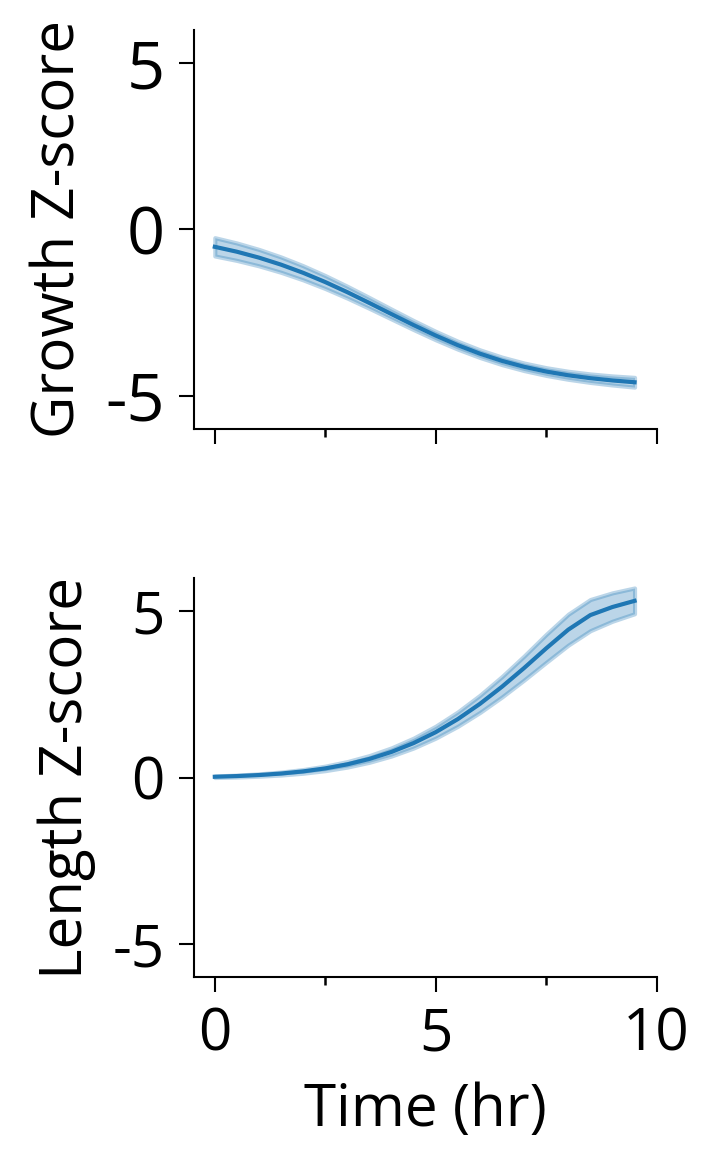

In [43]:
### time traces
gene_name = "rplQ"
sgrna_idx = 0

fig = plt.figure(figsize=(2.5,4))
ax = plt.subplot(2,1,1)

example_df = clustering_df[clustering_df["Gene"] == gene_name].iloc[sgrna_idx]
mean_series = example_df["Kernel Trace: Instantaneous Growth Rate: Volume: Transformed: z score"]
sem_series = example_df["SEM: Kernel Trace: Instantaneous Growth Rate: Volume: Transformed: z score"]

ax.plot(range(20),mean_series,color="tab:blue",zorder=-20)
# ax.scatter(range(20),mean_series,color="white",edgecolor="tab:blue",zorder=-15)
ax.fill_between(range(20),mean_series + (2*sem_series),mean_series-(2*sem_series),color="tab:blue",alpha=0.3)
ax.set_ylim(-6,6)
ax.set_yticks([-5,0,5],["-5","0","5"],fontsize=16)

ax.set_xticks([0,10,20],labels=["","",""],fontsize=14)
ax.set_xticks([5,15],labels=["",""],fontsize=14,minor=True)
# ax.set_xlabel("Time (hr)",fontsize=16)
ax.set_xlabel("  ",fontsize=14)
ax.set_ylabel(f"Growth Z-score",fontsize=14)

ax = plt.subplot(2,1,2)

mean_series = example_df["Kernel Trace: Length: Transformed: z score"]
sem_series = example_df["SEM: Kernel Trace: Length: Transformed: z score"]

ax.plot(range(20),mean_series,color="tab:blue",zorder=-20)
# ax.scatter(range(20),mean_series,color="white",edgecolor="tab:blue",zorder=-15)
ax.fill_between(range(20),mean_series + (2*sem_series),mean_series-(2*sem_series),color="tab:blue",alpha=0.3)
ax.set_ylim(-6,6)
ax.set_yticks([-5,0,5],["-5","0","5"],fontsize=14)

ax.set_xticks([0,10,20],labels=[0,5,10],fontsize=14)
ax.set_xticks([5,15],labels=["",""],fontsize=14,minor=True)
ax.set_xlabel("Time (hr)",fontsize=14)
ax.set_ylabel(f"Length Z-score",fontsize=14)
sns.despine(right=True,top=True)

plt.tight_layout()
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Figure_5/Growth_Length_Timeseries.png",\
            dpi=300,transparent=True,bbox_inches = "tight")

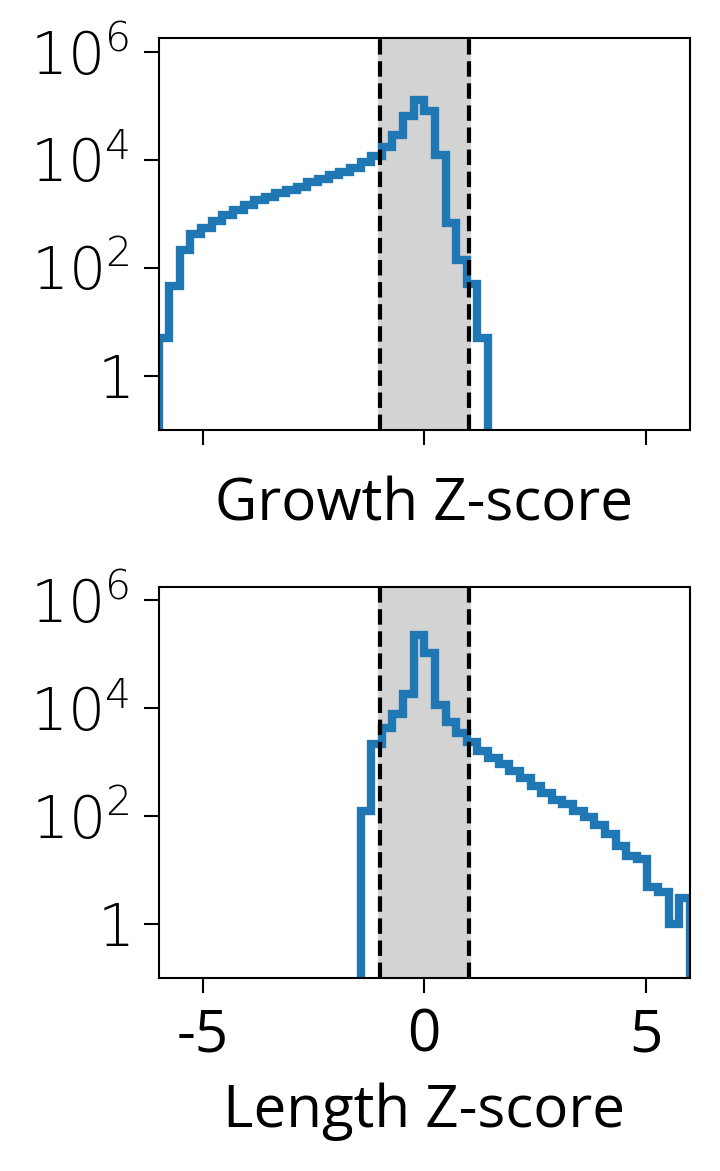

In [44]:
z_cutoff = 1

fig = plt.figure(figsize=(2.5,4))

ax = plt.subplot(2,1,1)

flat_values = np.array(clustering_df['Instantaneous Growth Rate: Volume: Z-score Timeseries'].values.tolist()).flatten()
plt.hist(flat_values,bins=50,histtype='step',range=(-6,6),density=False,\
         log=True,color="tab:blue",linewidth=2)
plt.yticks([1,100,10000,1000000],[r"$1$",r"$10^{2}$",r"$10^{4}$",r"$10^{6}$"],fontsize=14)
ymin, ymax = plt.ylim(0.1,1800000)
ax.set_xticks([-5,0,5],["","",""],fontsize=14)
ax.vlines([-z_cutoff,z_cutoff],ymin,ymax,color="black",linestyle="--")
ax.fill_betweenx([ymin,ymax,ymax,ymin],[z_cutoff,z_cutoff,-z_cutoff,-z_cutoff],color="lightgrey",alpha=1,zorder=-20)
ax.set_xlim(-6,6)
ax.set_xlabel(f"Growth Z-score",fontsize=14)

ax = plt.subplot(2,1,2)

flat_values = np.array(clustering_df['Length: Z-score Timeseries'].values.tolist()).flatten()
plt.hist(flat_values,bins=50,histtype='step',range=(-6,6),density=False,\
         log=True,color="tab:blue",linewidth=2)
plt.yticks([1,100,10000,1000000],[r"$1$",r"$10^{2}$",r"$10^{4}$",r"$10^{6}$"],fontsize=14)
ymin, ymax = plt.ylim(0.1,1800000)
ax.set_xticks([-5,0,5],["-5","0","5"],fontsize=14)
ax.vlines([-z_cutoff,z_cutoff],ymin,ymax,color="black",linestyle="--")
ax.fill_betweenx([ymin,ymax,ymax,ymin],[z_cutoff,z_cutoff,-z_cutoff,-z_cutoff],color="lightgrey",alpha=1,zorder=-20)
ax.set_xlim(-6,6)
ax.set_xlabel(f"Length Z-score",fontsize=14)
plt.tight_layout()
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Figure_5/Growth_Length_Hist.png",\
            dpi=300,transparent=True,bbox_inches = "tight")

### Center

In [45]:
# bootstrapping z-score thresholds
paramter_name = 'Instantaneous Growth Rate: Volume'
upper_cutoff_growth = np.min(clustering_df[(clustering_df[paramter_name + ': Last Timepoint Z-score']>z_cutoff)]["8 Hours: Kernel Trace: " + paramter_name])
lower_cutoff_growth = np.max(clustering_df[(clustering_df[paramter_name + ': Last Timepoint Z-score']<-z_cutoff)]["8 Hours: Kernel Trace: " + paramter_name])

paramter_name = 'Length'
upper_cutoff_length = np.min(clustering_df[(clustering_df[paramter_name + ': Last Timepoint Z-score']>z_cutoff)]["8 Hours: Kernel Trace: " + paramter_name])
lower_cutoff_length = np.max(clustering_df[(clustering_df[paramter_name + ': Last Timepoint Z-score']<-z_cutoff)]["8 Hours: Kernel Trace: " + paramter_name])

paramter_name = 'Width'
upper_cutoff_width = np.min(clustering_df[(clustering_df[paramter_name + ': Last Timepoint Z-score']>z_cutoff)]["8 Hours: Kernel Trace: " + paramter_name])
lower_cutoff_width = np.max(clustering_df[(clustering_df[paramter_name + ': Last Timepoint Z-score']<-z_cutoff)]["8 Hours: Kernel Trace: " + paramter_name])

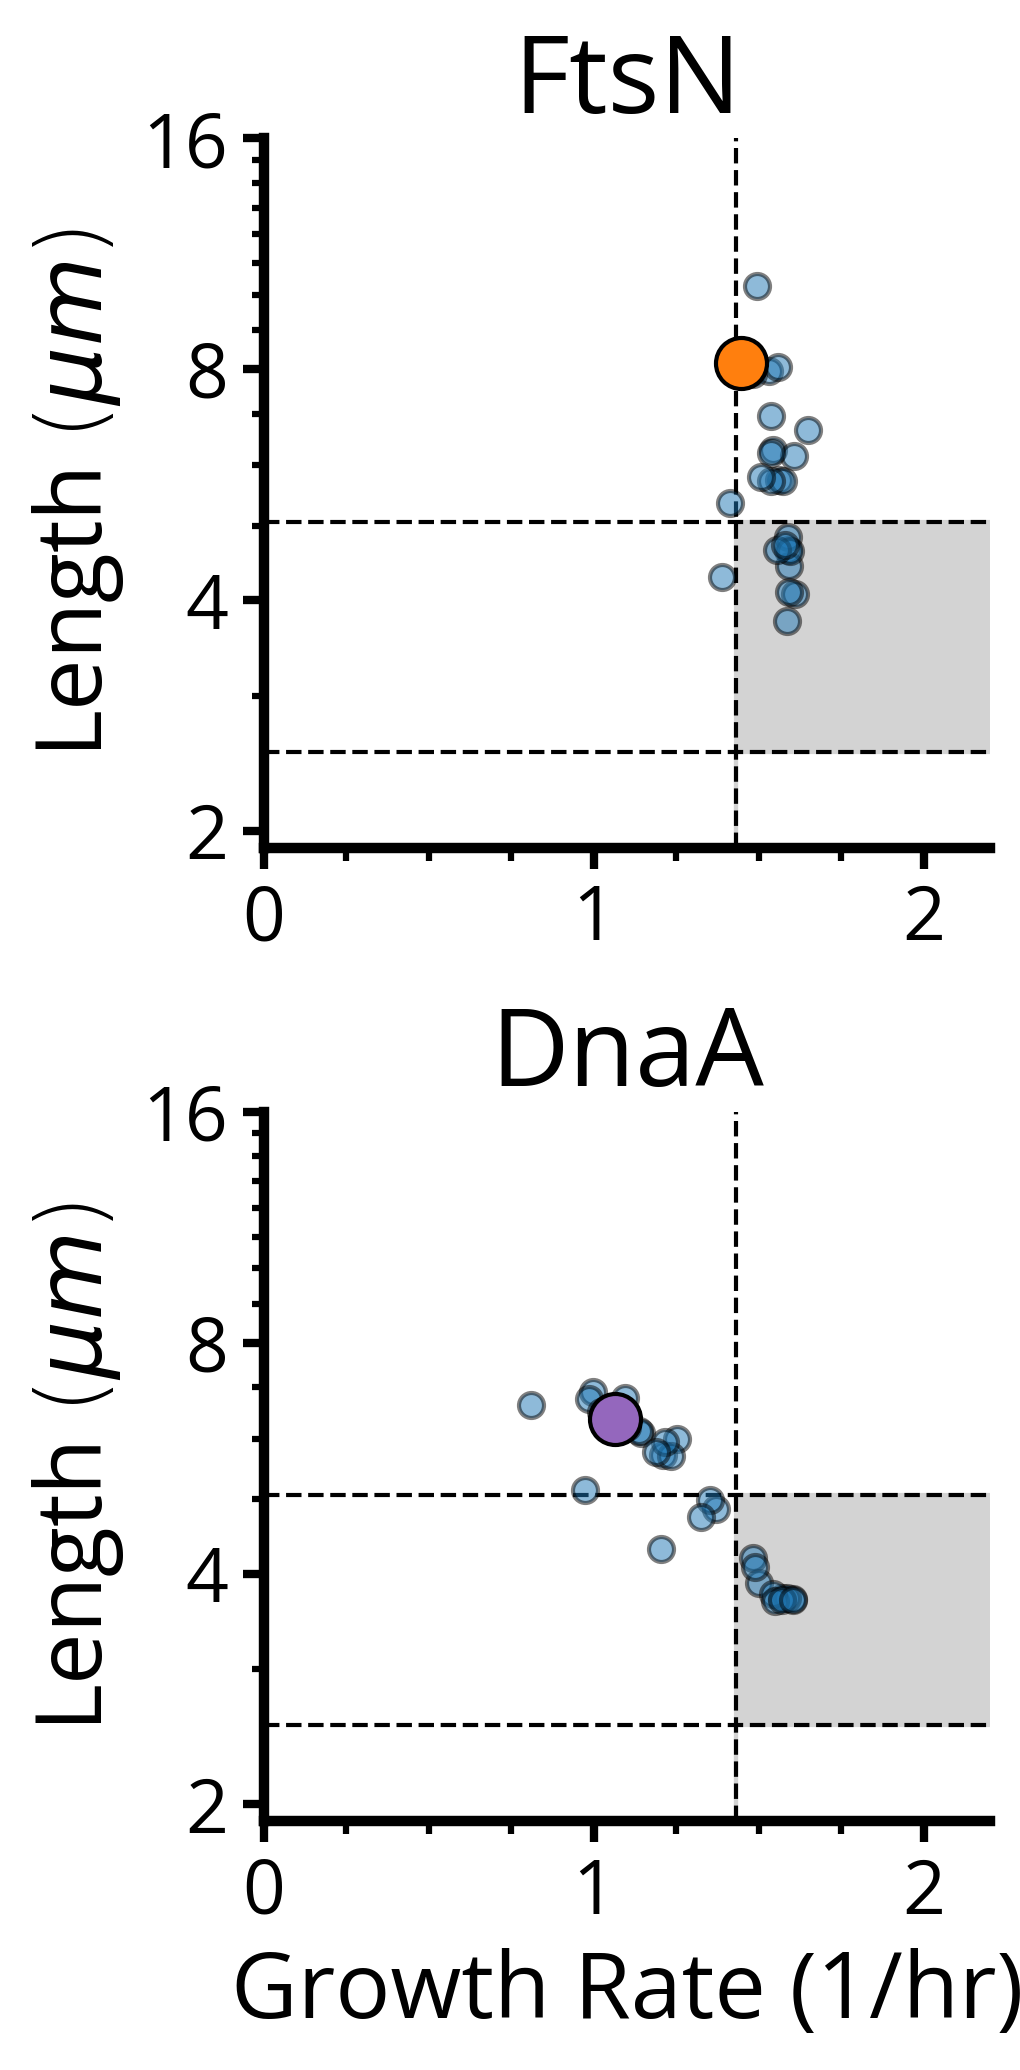

In [46]:
fig = plt.figure(figsize=(3.5,7))

ax = plt.subplot(2,1,1)

ax.set_title("FtsN",fontsize=26)
ftsN_highlighted_sgrna = 9576
ftsN_df = clustering_df[clustering_df["Gene"] == "ftsN"]
ftsN_df_highlighted_sgrna = ftsN_df.loc[[ftsN_highlighted_sgrna]]

ax.scatter(ftsN_df["8 Hours: Kernel Trace: Instantaneous Growth Rate: Volume"],ftsN_df["8 Hours: Kernel Trace: Length"],edgecolors='black',alpha=0.5,zorder=90)
ax.scatter(ftsN_df_highlighted_sgrna["8 Hours: Kernel Trace: Instantaneous Growth Rate: Volume"],\
           ftsN_df_highlighted_sgrna["8 Hours: Kernel Trace: Length"],edgecolors='black',\
           alpha=1,zorder=100,color="tab:orange",s=150)

ax.set_xlabel("",fontsize=20)
ax.set_ylabel("Length $ (\mu m) $",fontsize=22)
xmin, xmax = ax.set_xlim(0,2.2)
ymin, ymax = ax.set_ylim(1.9,16)
ax.set_yscale("log")
ax.set_yticks(ticks=[2,4,8,16],labels=["2","4","8","16"],fontsize=16,minor=False)
ax.set_xticks(ticks=[0,1.,2.],labels=["0","1","2"],minor=False)
ax.set_yticks(ticks=[3,5,6,7,9,10,11,12,13,14,15],labels=[],minor=True)
ax.set_xticks(ticks=[0.25,0.5,0.75,1.25,1.5,1.75],labels=[],minor=True)
ax.tick_params(axis='both', direction='out', labelsize=18,  width=2, length=5)
ax.tick_params(axis='both', direction='out', labelsize=18,  width=1.5, which='minor', length=3)
ax.spines['bottom'].set_linewidth(2.5) # Set thickness of the bottom spine
ax.spines['left'].set_linewidth(2.5)   # Set thickness of the left spine
sns.despine(right=True,top=True)

ax.hlines([lower_cutoff_length,upper_cutoff_length],xmin,xmax,color="black",linestyle="--")
ax.vlines([lower_cutoff_growth],ymin,ymax,color="black",linestyle="--")

ax.fill_between([lower_cutoff_growth,lower_cutoff_growth,xmax,xmax,lower_cutoff_growth],\
                [lower_cutoff_length,upper_cutoff_length,upper_cutoff_length,lower_cutoff_length,lower_cutoff_length],\
                color="lightgrey",alpha=1,zorder=-20)


ax = plt.subplot(2,1,2)

ax.set_title("DnaA",fontsize=26)
dnaA_highlighted_sgrna = 8866
dnaA_df = clustering_df[clustering_df["Gene"] == "dnaA"]
dnaA_df_highlighted_sgrna = dnaA_df.loc[[dnaA_highlighted_sgrna]]

ax.scatter(dnaA_df["8 Hours: Kernel Trace: Instantaneous Growth Rate: Volume"],dnaA_df["8 Hours: Kernel Trace: Length"],edgecolors='black',alpha=0.5,zorder=90)
ax.scatter(dnaA_df_highlighted_sgrna["8 Hours: Kernel Trace: Instantaneous Growth Rate: Volume"],\
           dnaA_df_highlighted_sgrna["8 Hours: Kernel Trace: Length"],edgecolors='black',\
           alpha=1,zorder=100,color="tab:purple",s=150)
ax.set_xlabel("Growth Rate (1/hr)",fontsize=22)
ax.set_ylabel("Length $ (\mu m) $",fontsize=22)
xmin, xmax = ax.set_xlim(0,2.2)
ymin, ymax = ax.set_ylim(1.9,16)
ax.set_yscale("log")
ax.set_yticks(ticks=[2,4,8,16],labels=["2","4","8","16"],fontsize=16,minor=False)
ax.set_xticks(ticks=[0,1.,2.],labels=["0","1","2"],minor=False)
ax.set_yticks(ticks=[3,5,6,7,9,10,11,12,13,14,15],labels=[],minor=True)
ax.set_xticks(ticks=[0.25,0.5,0.75,1.25,1.5,1.75],labels=[],minor=True)
ax.tick_params(axis='both', direction='out', labelsize=18,  width=2, length=5)
ax.tick_params(axis='both', direction='out', labelsize=18,  width=1.5, which='minor', length=3)
ax.spines['bottom'].set_linewidth(2.5) # Set thickness of the bottom spine
ax.spines['left'].set_linewidth(2.5)   # Set thickness of the left spine
sns.despine(right=True,top=True)

ax.hlines([lower_cutoff_length,upper_cutoff_length],xmin,xmax,color="black",linestyle="--")
ax.vlines([lower_cutoff_growth],ymin,ymax,color="black",linestyle="--")

ax.fill_between([lower_cutoff_growth,lower_cutoff_growth,xmax,xmax,lower_cutoff_growth],\
                [lower_cutoff_length,upper_cutoff_length,upper_cutoff_length,lower_cutoff_length,lower_cutoff_length],\
                color="lightgrey",alpha=1,zorder=-20)

plt.tight_layout()
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Figure_5/Growth_Length_Scatter.png",\
            dpi=300,transparent=True,bbox_inches = "tight")

### Right

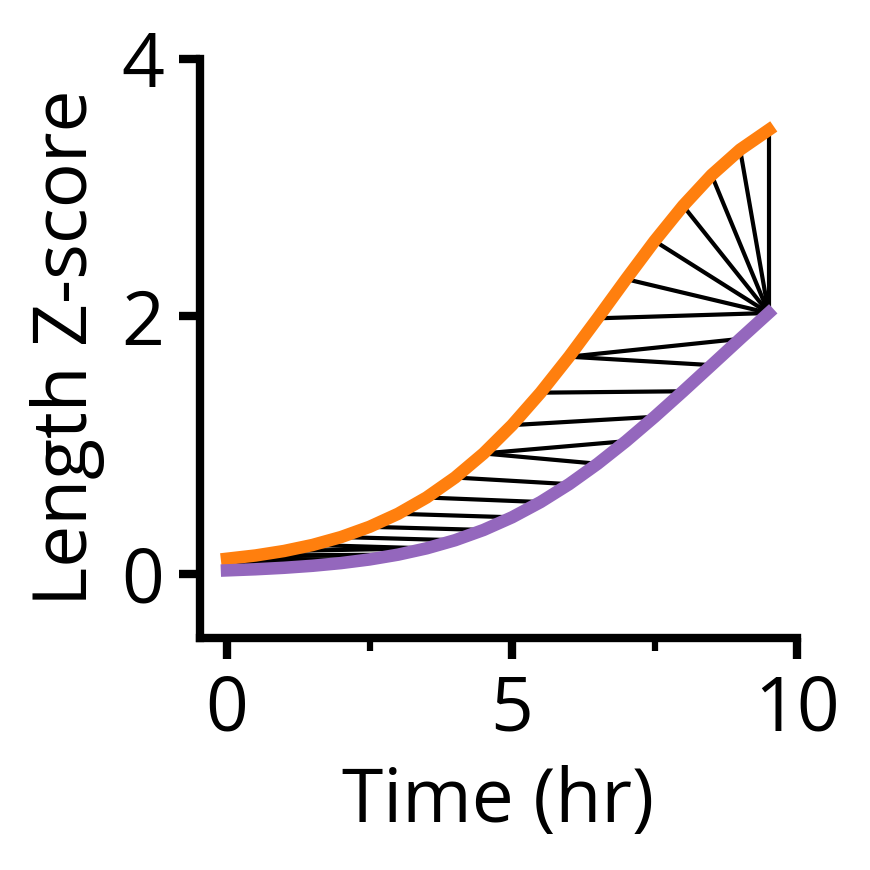

In [47]:
ftsN_signal = ftsN_df_highlighted_sgrna["Kernel Trace: Length: Transformed: z score"].iloc[0]
dnaA_signal = dnaA_df_highlighted_sgrna["Kernel Trace: Length: Transformed: z score"].iloc[0]

s_y1 = ftsN_signal.reshape((-1, 1))
s_y2 = dnaA_signal.reshape((-1, 1))
sz = s_y1.shape[0]

gamma = 1
alignment, sim = metrics.soft_dtw_alignment(s_y1, s_y2, gamma=gamma)
hard_alignment,hard_sim = metrics.dtw_path(s_y1, s_y2)

#### Simplified chordmap of the alignment from above
plt.figure(figsize=(3, 3))
ax = plt.subplot(1,1,1)

ax.plot(ftsN_signal,color="tab:orange",linewidth=3)
ax.plot(dnaA_signal,color="tab:purple",linewidth=3)

chords = np.array([(connection[0],ftsN_signal[connection[0]],connection[1],dnaA_signal[connection[1]]) for connection in hard_alignment])

for chord in chords:
    # working_chord_arr = 
    # plt.scatter(chord[0],chord[1],color="tab:orange")
    # plt.scatter(chord[2],chord[3])
    ax.plot([chord[0],chord[2]],[chord[1],chord[3]],color="black",zorder=-20)

ax.set_ylim(-0.5,4)
ax.set_yticks([0,2,4],["0","2","4"],fontsize=18)
ax.set_xticks([0,10,20],labels=[0,5,10],fontsize=18)
ax.set_xticks([5,15],labels=["",""],fontsize=18,minor=True)
ax.set_xlabel("Time (hr)",fontsize=18)
ax.set_ylabel(r"Length Z-score",fontsize=18)

ax.tick_params(axis='both', direction='out', labelsize=18,  width=2, length=5)
ax.tick_params(axis='both', direction='out', labelsize=18,  width=1.5, which='minor', length=3)

ax.spines['bottom'].set_linewidth(2) # Set thickness of the bottom spine
ax.spines['left'].set_linewidth(2)   # Set thickness of the left spine

sns.despine(right=True,top=True)
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Figure_5/Length_SoftDTW_chords.png",\
            dpi=300,transparent=True,bbox_inches = "tight")

In [ ]:
fig = plt.figure(figsize=(8,8))
sns.heatmap(an_df_clustree.obsp['soft_dtw'],cmap="BuPu",cbar=False,vmin=0,vmax=600)
plt.axis('off')
plt.tight_layout()
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Figure_5/Distance_Matrix.png", dpi=300, edgecolor='none')

## Figure 5B

/tmp/ipykernel_35359/3380097720.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(umap_background_fig_df["X Coord"],umap_background_fig_df["Y Coord"],c=grey_rgb,s=5,zorder=-1)


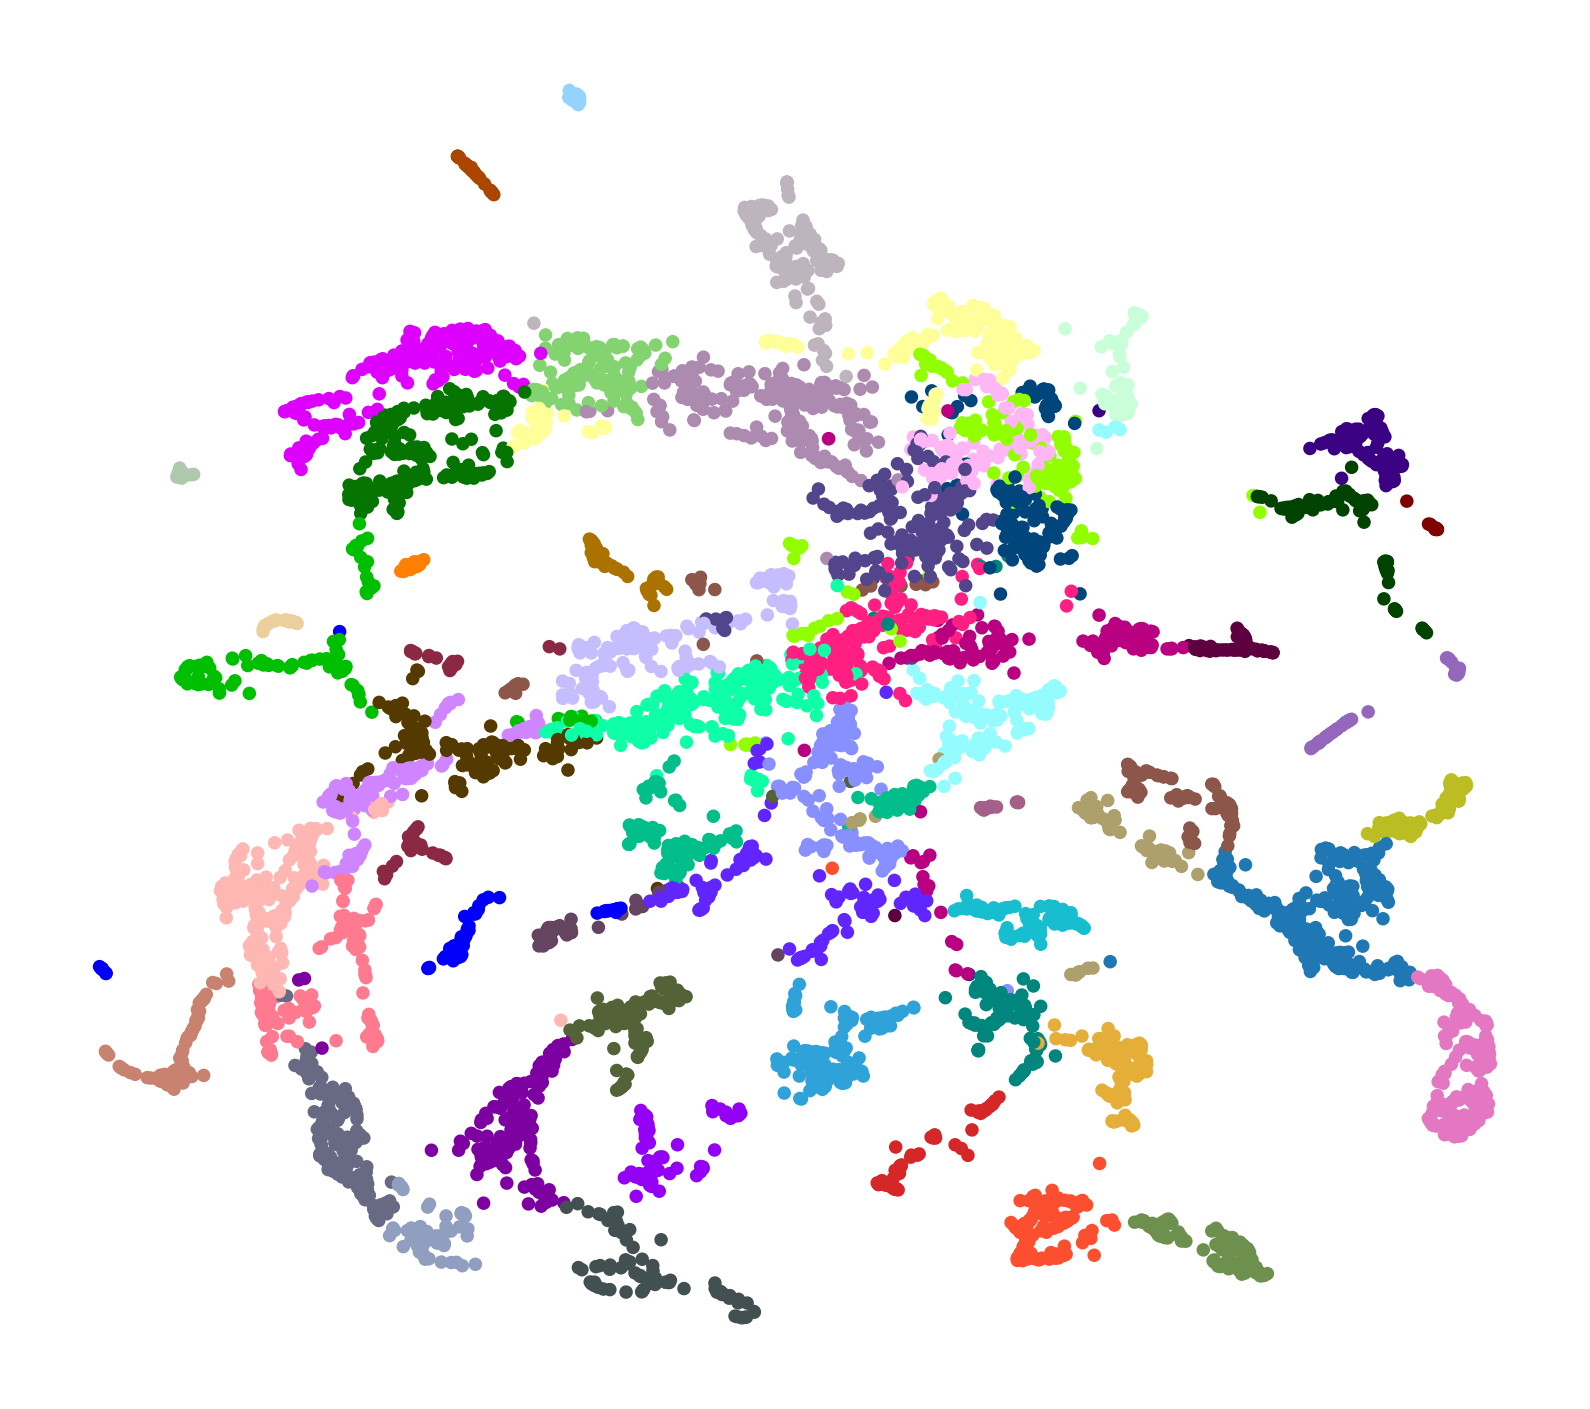

In [48]:
grey_mask = (umap_fig_df["All Colors"] == grey_rgb)
umap_background_fig_df = umap_fig_df[grey_mask]
umap_foreground_fig_df = umap_fig_df[~grey_mask]

fig = plt.figure(figsize=(5.4, 4.8))

plt.scatter(umap_background_fig_df["X Coord"],umap_background_fig_df["Y Coord"],c=grey_rgb,s=5,zorder=-1)
plt.scatter(umap_foreground_fig_df["X Coord"],umap_foreground_fig_df["Y Coord"],c=umap_foreground_fig_df["All Colors"],s=5,zorder=1)

sns.despine(left=True,bottom=True)
plt.xlabel("")
plt.ylabel("")
plt.xticks([])
plt.yticks([])
plt.title("",fontsize=20)
plt.tight_layout()
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Figure_5/Highlighted_UMAP_All_Colors.png",dpi=300,\
            transparent=True,bbox_inches = "tight")

## Figure 5C

Searching for divisome complex


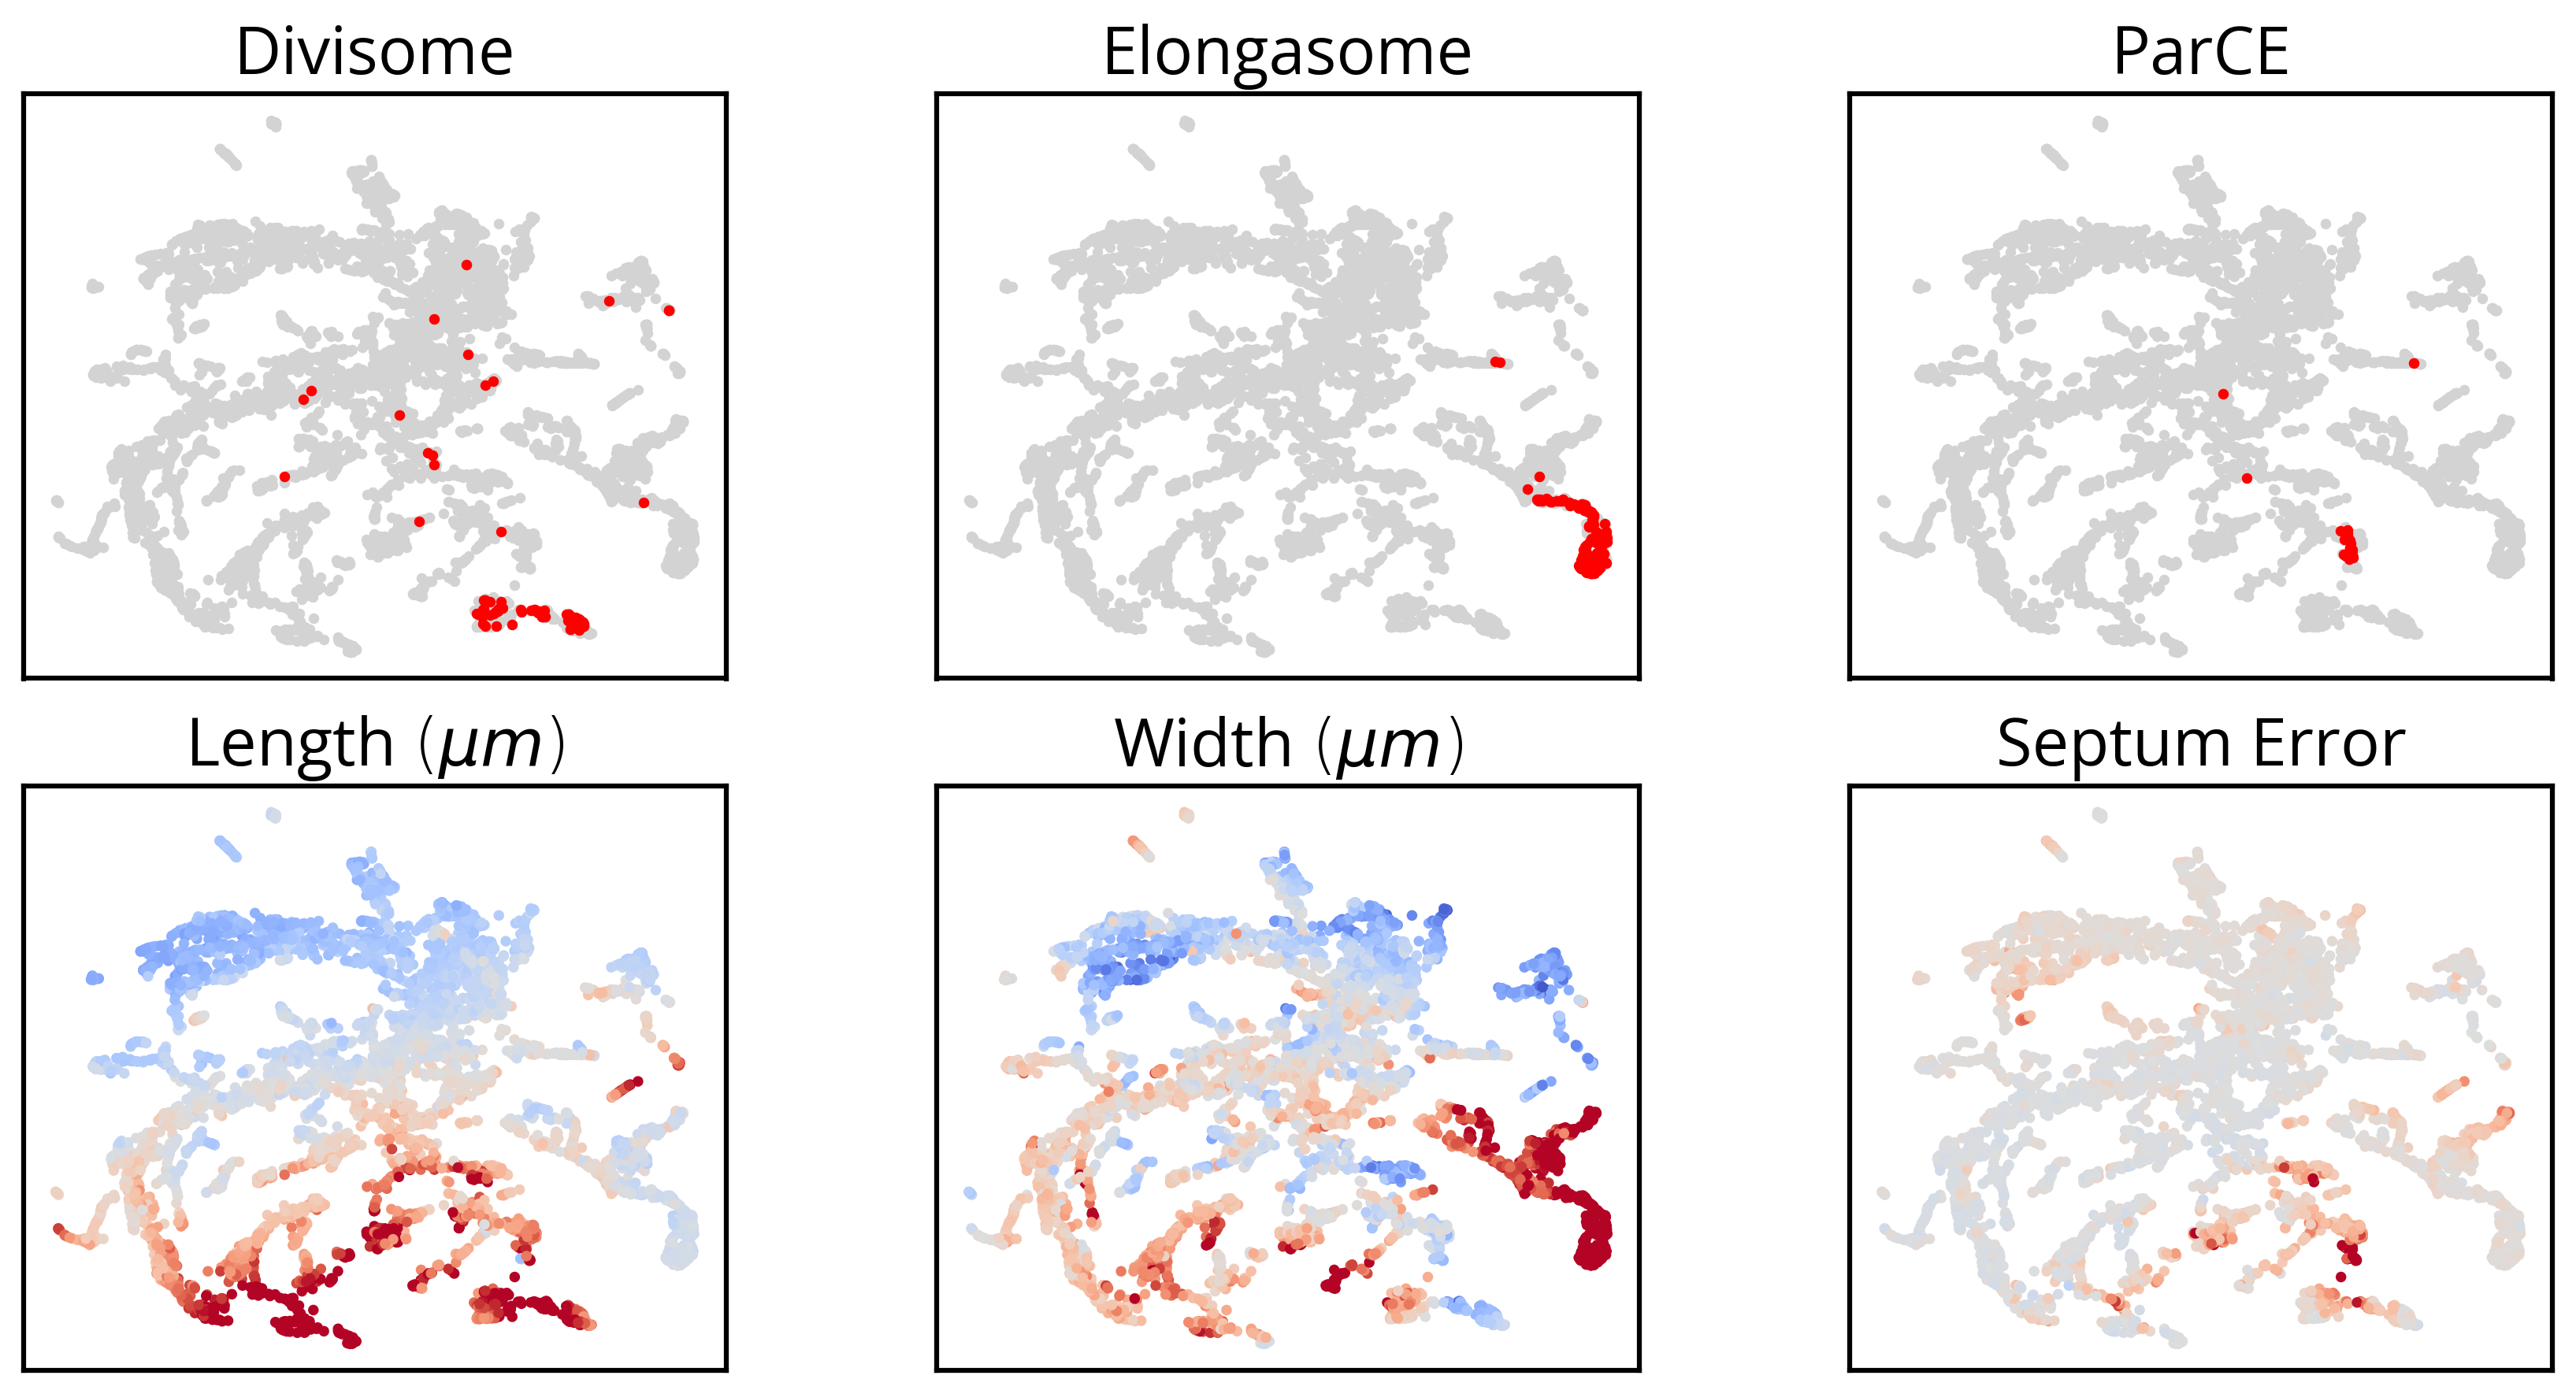

In [49]:
divisome_genes = search_go(ns2assoc, obodag, inv_gene_to_id, "GO:1990586")
rod_complex_genes = ["mreB","mreC","mreD","RodZ","mrdB","mrdA"]
par_genes = ["parC","parE"]

gene_groups_list = [divisome_genes,rod_complex_genes,par_genes]
gene_group_names = ["Divisome","Elongasome","ParCE"]
phenotype_indices = [2,3,1]
pheno_labels_of_interest = [all_labels[idx] for idx in phenotype_indices]
title_list_of_interest = [title_list[idx] for idx in phenotype_indices]
min_vals_of_interest = [min_vals[idx] for idx in phenotype_indices]
max_vals_of_interest = [max_vals[idx] for idx in phenotype_indices]
cbar_ticks_of_interest = [cbar_ticks_list[idx] for idx in phenotype_indices]

fig = plt.figure(figsize=(11,6))
# fig, axs = plt.subplots(2,3,figsize=(16,11))

for i,gene_group in enumerate(gene_groups_list):
    gene_groups_name = gene_group_names[i]
    ax = plt.subplot(2,3,i+1)

    genes_umap = umap_fig_df[umap_fig_df["Gene"].isin(gene_group)]
    no_genes_umap = umap_fig_df[~umap_fig_df["Gene"].isin(gene_group)]
    
    plt.scatter(genes_umap["X Coord"],genes_umap["Y Coord"],c="red",s=5,zorder=-10)
    plt.scatter(no_genes_umap["X Coord"],no_genes_umap["Y Coord"],c="lightgrey",s=5,zorder=-11)
    plt.title(gene_groups_name,fontsize=20)
    # Remove ticks
    ax.set_xticks([])  # Removes x-axis ticks
    ax.set_yticks([])  # Removes y-axis ticks
    
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)  # Set the thickness of the frame. Adjust the number to change the thickness.


for i,pheno_label in enumerate(pheno_labels_of_interest):
    ax = plt.subplot(2,3,i+4)
    plt.title(str(title_list_of_interest[i]), fontsize=20)
    scatterout = plt.scatter(umap_fig_df["X Coord"],umap_fig_df["Y Coord"],
                c=umap_fig_df[pheno_label],s=5,zorder=1,\
                vmin=min_vals_of_interest[i],vmax=max_vals_of_interest[i],cmap="coolwarm")
    plt.yticks([])
    plt.xticks([])
    if i == 0:
        plt.ylabel("", fontsize=18)
    elif i == 1:
        plt.xlabel("", fontsize=18)
        
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)  # Set the thickness of the frame. Adjust the number to change the thickness.

plt.tight_layout()
fig.subplots_adjust(wspace=0.3)
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Figure_5/UMAP_Parameters_and_GO.png",\
            dpi=300,transparent=True,bbox_inches = "tight")

### Generate Colorbars

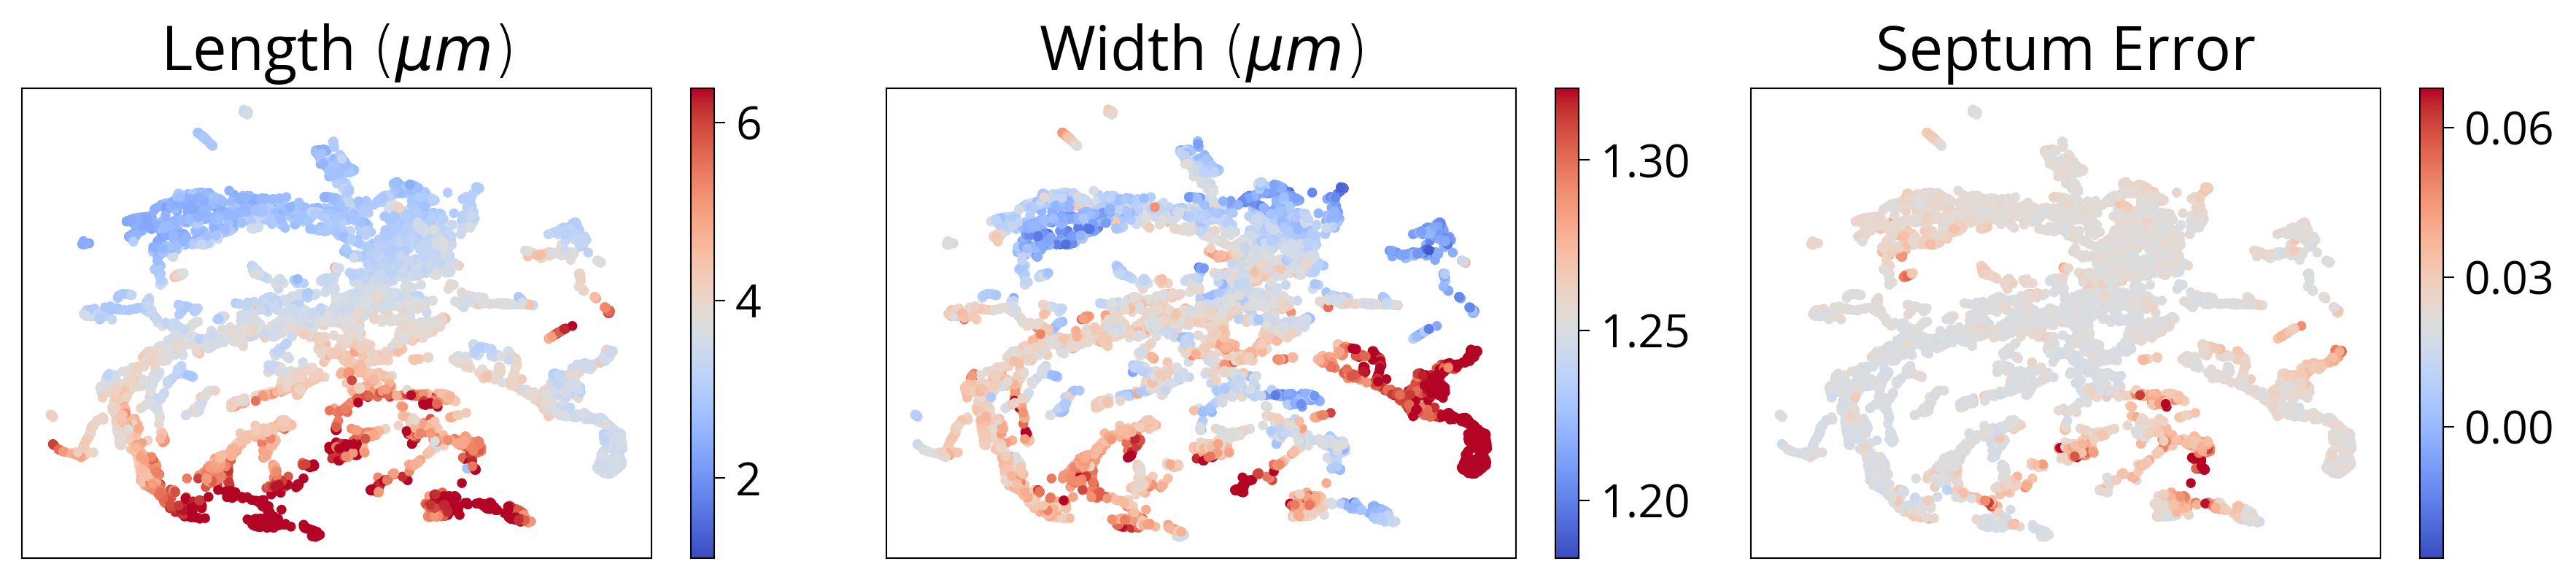

In [50]:
fig = plt.figure(figsize=(12,2.75))
# fig, axs = plt.subplots(2,3,figsize=(16,11))
for i,pheno_label in enumerate(pheno_labels_of_interest):
    plt.subplot(1,3,i+1)
    # axs[0,i].scatter(umap_fig_df["X Coord"],umap_fig_df["Y Coord"],c=umap_fig_df[cluster_level + " Color"],s=5,zorder=1)
    plt.title(str(title_list_of_interest[i]), fontsize=20)
    scatterout = plt.scatter(umap_fig_df["X Coord"],umap_fig_df["Y Coord"],
                c=umap_fig_df[pheno_label],s=5,zorder=1,\
                vmin=min_vals_of_interest[i],vmax=max_vals_of_interest[i],cmap="coolwarm")
    # cax = fig.add_axes([0.27, 0.8, 0.5, 0.05])
    # fig.colorbar(scatterout, cax=cax, orientation='vertical')
    # Adding a colorbar
    cbar = plt.colorbar(scatterout, label='')
    cbar.set_ticks(cbar_ticks_of_interest[i])
    cbar.ax.tick_params(labelsize=15)


    plt.yticks([])
    plt.xticks([])
    if i == 0:
        plt.ylabel("", fontsize=18)
    elif i == 1:
        plt.xlabel("", fontsize=18)
plt.tight_layout()
fig.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Figure_5/UMAP_Parameters_and_GO_Cbars.png",dpi=300,bbox_inches='tight')

### Kymographs

In [21]:
headpath = "/home/de64/scratch/de64/sync_folder/2023-03-11_lDE26_Run_1"
variant_library_path = headpath + "/Variant_Library"
base_export_path = "/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Figure_5/Kymographs"

## Setting up scale bar
scale_bar_size_um = 10
scale_bar_thickness = 2

scalebar_color = 'white'  # Color of the scale bar
scalebar_y_position = 200 # Y-position of the scale bar in data units
scalebar_x_position = 20  # X-position of the scale bar in data units
pixel_microns = 0.106
scale_bar_size_pixels = scale_bar_size_um//pixel_microns

#### ftsW

In [22]:
gene_name = "ftsW" 
gene_df = nucleoid_df[nucleoid_df["Gene"] == gene_name]
gene_df["Kernel Trace: Length"].apply(lambda x:x[-1])

oDEPool7_id
6694     5.275738
22136    8.369290
Name: Kernel Trace: Length, dtype: float64

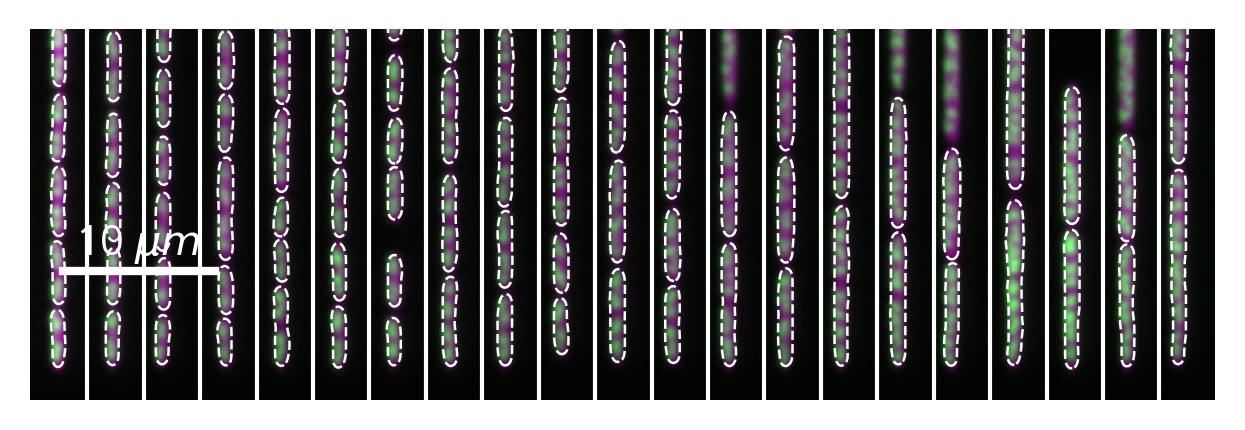

In [23]:
# sgrna index
sgrnaid = 22136
# fetch trench
trenchidx = 5

# time definition
t_step = 3
# t_step = 1
t_i = 0
cropx = 1

min_intensity_green = 0
max_intensity_green = 15000

min_intensity_magenta = 0
max_intensity_magenta = 50000
magenta_weight = 0.8
green_weight = 1

scalebar_on = True
genename_on = False

tr.writedir(base_export_path,overwrite=False)
data = lookup_variant(variant_library_path,"YFP",sgrnaid,[trenchidx])[0,t_i::t_step,:,cropx:-cropx]
nuc_data = lookup_variant(variant_library_path,"mCherry",sgrnaid,[trenchidx])[0,t_i::t_step,:,cropx:-cropx]
seg_data = lookup_variant(variant_library_path,"Segmentation",sgrnaid,[trenchidx])[0,t_i::t_step,:,cropx:-cropx]

cyto_output = np.concatenate([data[t] for t in range(data.shape[0])],axis=1)
nuc_output = np.concatenate([nuc_data[t] for t in range(nuc_data.shape[0])],axis=1)

seg_output = []
for t in range(seg_data.shape[0]):
    working_seg_data = seg_data[t]
    working_seg_data[working_seg_data>0] = working_seg_data[working_seg_data>0]+(100*t)
    seg_output.append(working_seg_data)
    
seg_output = np.concatenate(seg_output,axis=1)
seg_output, _, _ = sk.segmentation.relabel_sequential(seg_output)

seg_borders_list = []
for i in range(1,np.max(seg_output)+1):
    seg_borders = sk.measure.find_contours(sk.filters.gaussian(seg_output == i,sigma=3), level=0.5)[0]
    seg_borders_list.append(seg_borders)

merged_image = get_magenta_green_overlay(nuc_output,cyto_output,min_intensity_green,max_intensity_green,\
                                       min_intensity_magenta,max_intensity_magenta,mag_weight=magenta_weight,\
                                        green_weight=green_weight)

# # # np.clip(img_green.astype(np.uint32) + img_magenta.astype(np.uint32), 0, 65535).astype(np.uint16)
plt.imshow(sk.util.img_as_ubyte(merged_image))
for seg_border in seg_borders_list:
    plt.plot(seg_border[:,1],seg_border[:,0],color="white",linestyle="--",linewidth=0.6)
plt.ylim(280,50)

if genename_on:
    plt.text(5,
            60,
            f"{gene_name}",
            fontdict={'style': 'italic'},
            color=scalebar_color,
            verticalalignment='top',
            horizontalalignment='left',
            fontsize=40)
# Add a label next to the scale bar
if scalebar_on:
    # Draw the scale bar
    plt.plot([scalebar_x_position, scalebar_x_position + scale_bar_size_pixels],
                [scalebar_y_position, scalebar_y_position],
                color=scalebar_color,
                linewidth=scale_bar_thickness)
    # Add a label next to the scale bar
    plt.text(scalebar_x_position + scale_bar_size_pixels / 2,
            scalebar_y_position-30,
            f'{scale_bar_size_um} $\mu m$',
            color=scalebar_color,
            verticalalignment='top',
            horizontalalignment='center',
            fontsize=10)
plt.vlines([(data.shape[2]*t) for t in range(1,data.shape[0])],-1.5,660.5,linestyle="-",color="white",linewidth=1,zorder=20)
plt.axis('off')
plt.savefig(base_export_path + "/" + gene_name + "_" + str(sgrnaid) + ".png",transparent=True,dpi=500,\
            bbox_inches="tight")
# plt.savefig(base_export_path + "/" + gene_name + "_" + str(sgrnaid) + "_scale.png",transparent=True,dpi=500,\
#             bbox_inches="tight")

#### mreB

In [24]:
gene_name = "mreB" 
gene_df = nucleoid_df[nucleoid_df["Gene"] == gene_name]
gene_df["Kernel Trace: Width"].apply(lambda x:x[-1])

oDEPool7_id
22512    1.163008
Name: Kernel Trace: Width, dtype: float64

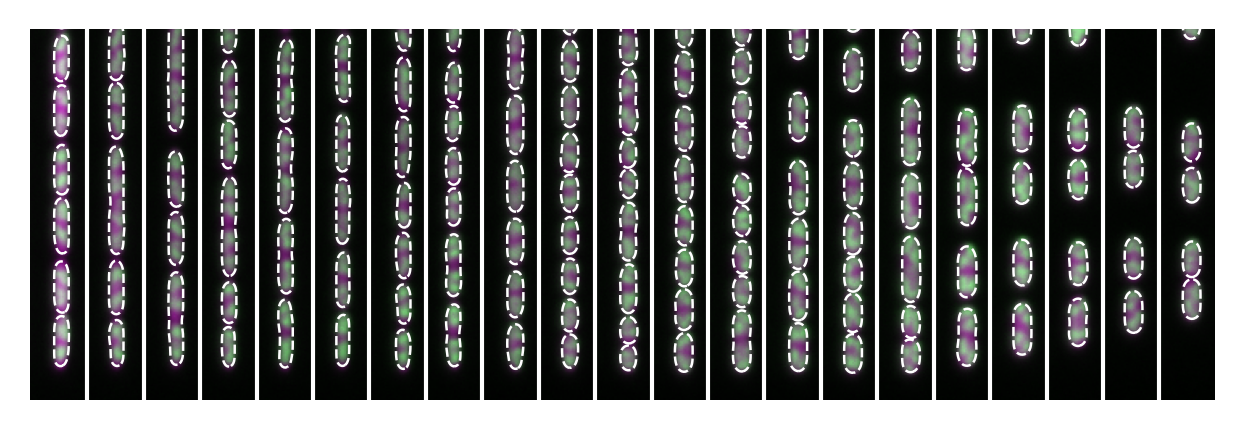

In [25]:
# sgrna index
sgrnaid = 22512
# fetch trench
trenchidx = 13

# time definition
t_step = 3
# t_step = 1
t_i = 0
cropx = 1

min_intensity_green = 0
max_intensity_green = 15000

min_intensity_magenta = 0
max_intensity_magenta = 50000
magenta_weight = 0.8
green_weight = 1

scalebar_on = False
genename_on = False

tr.writedir(base_export_path,overwrite=False)
data = lookup_variant(variant_library_path,"YFP",sgrnaid,[trenchidx])[0,t_i::t_step,:,cropx:-cropx]
nuc_data = lookup_variant(variant_library_path,"mCherry",sgrnaid,[trenchidx])[0,t_i::t_step,:,cropx:-cropx]
seg_data = lookup_variant(variant_library_path,"Segmentation",sgrnaid,[trenchidx])[0,t_i::t_step,:,cropx:-cropx]

cyto_output = np.concatenate([data[t] for t in range(data.shape[0])],axis=1)
nuc_output = np.concatenate([nuc_data[t] for t in range(nuc_data.shape[0])],axis=1)

seg_output = []
for t in range(seg_data.shape[0]):
    working_seg_data = seg_data[t]
    working_seg_data[working_seg_data>0] = working_seg_data[working_seg_data>0]+(100*t)
    seg_output.append(working_seg_data)
    
seg_output = np.concatenate(seg_output,axis=1)
seg_output, _, _ = sk.segmentation.relabel_sequential(seg_output)

seg_borders_list = []
for i in range(1,np.max(seg_output)+1):
    seg_borders = sk.measure.find_contours(sk.filters.gaussian(seg_output == i,sigma=3), level=0.5)[0]
    seg_borders_list.append(seg_borders)

merged_image = get_magenta_green_overlay(nuc_output,cyto_output,min_intensity_green,max_intensity_green,\
                                       min_intensity_magenta,max_intensity_magenta,mag_weight=magenta_weight,\
                                        green_weight=green_weight)

# # # np.clip(img_green.astype(np.uint32) + img_magenta.astype(np.uint32), 0, 65535).astype(np.uint16)
plt.imshow(sk.util.img_as_ubyte(merged_image))
for seg_border in seg_borders_list:
    plt.plot(seg_border[:,1],seg_border[:,0],color="white",linestyle="--",linewidth=0.6)
plt.ylim(280,50)

if genename_on:
    plt.text(5,
            60,
            f"{gene_name}",
            fontdict={'style': 'italic'},
            color=scalebar_color,
            verticalalignment='top',
            horizontalalignment='left',
            fontsize=40)
# Add a label next to the scale bar
if scalebar_on:
    # Draw the scale bar
    plt.plot([scalebar_x_position, scalebar_x_position + scale_bar_size_pixels],
                [scalebar_y_position, scalebar_y_position],
                color=scalebar_color,
                linewidth=scale_bar_thickness,zorder=100)
    # Add a label next to the scale bar
    plt.text(scalebar_x_position + scale_bar_size_pixels / 2,
            scalebar_y_position-30,
            f'{scale_bar_size_um} $\mu m$',
            color=scalebar_color,
            verticalalignment='top',
            horizontalalignment='center',
            fontsize=10)
plt.vlines([(data.shape[2]*t) for t in range(1,data.shape[0])],-1.5,660.5,linestyle="-",color="white",linewidth=1,zorder=20)
plt.axis('off')
plt.savefig(base_export_path + "/" + gene_name + "_" + str(sgrnaid) + ".png",transparent=True,dpi=500,\
            bbox_inches="tight")

#### parC

In [26]:
gene_name = "parC" 
gene_df = nucleoid_df[nucleoid_df["Gene"] == gene_name]
gene_df["Kernel Trace: Width"].apply(lambda x:x[-1])

oDEPool7_id
922    0.897322
Name: Kernel Trace: Width, dtype: float64

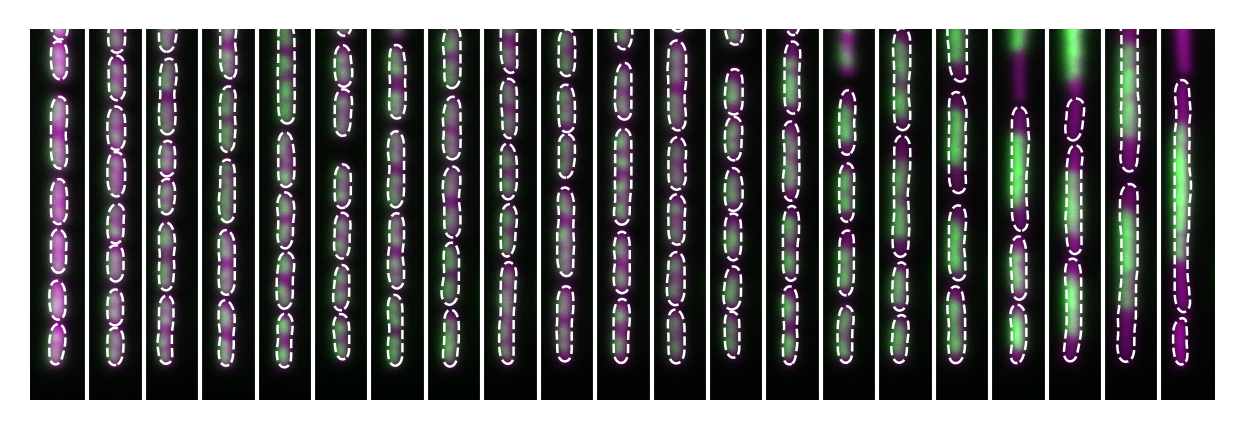

In [27]:
# sgrna index
sgrnaid = 922
# fetch trench
trenchidx = 0

# time definition
t_step = 3
# t_step = 1
t_i = 0
cropx = 1

min_intensity_green = 0
max_intensity_green = 15000

min_intensity_magenta = 0
max_intensity_magenta = 50000
magenta_weight = 0.8
green_weight = 1

scalebar_on = False
genename_on = False

tr.writedir(base_export_path,overwrite=False)
data = lookup_variant(variant_library_path,"YFP",sgrnaid,[trenchidx])[0,t_i::t_step,:,cropx:-cropx]
nuc_data = lookup_variant(variant_library_path,"mCherry",sgrnaid,[trenchidx])[0,t_i::t_step,:,cropx:-cropx]
seg_data = lookup_variant(variant_library_path,"Segmentation",sgrnaid,[trenchidx])[0,t_i::t_step,:,cropx:-cropx]

cyto_output = np.concatenate([data[t] for t in range(data.shape[0])],axis=1)
nuc_output = np.concatenate([nuc_data[t] for t in range(nuc_data.shape[0])],axis=1)

seg_output = []
for t in range(seg_data.shape[0]):
    working_seg_data = seg_data[t]
    working_seg_data[working_seg_data>0] = working_seg_data[working_seg_data>0]+(100*t)
    seg_output.append(working_seg_data)
    
seg_output = np.concatenate(seg_output,axis=1)
seg_output, _, _ = sk.segmentation.relabel_sequential(seg_output)

seg_borders_list = []
for i in range(1,np.max(seg_output)+1):
    seg_borders = sk.measure.find_contours(sk.filters.gaussian(seg_output == i,sigma=3), level=0.5)[0]
    seg_borders_list.append(seg_borders)

merged_image = get_magenta_green_overlay(nuc_output,cyto_output,min_intensity_green,max_intensity_green,\
                                       min_intensity_magenta,max_intensity_magenta,mag_weight=magenta_weight,\
                                        green_weight=green_weight)

# # # np.clip(img_green.astype(np.uint32) + img_magenta.astype(np.uint32), 0, 65535).astype(np.uint16)
plt.imshow(sk.util.img_as_ubyte(merged_image))
for seg_border in seg_borders_list:
    plt.plot(seg_border[:,1],seg_border[:,0],color="white",linestyle="--",linewidth=0.6)
plt.ylim(280,50)

if genename_on:
    plt.text(5,
            60,
            f"{gene_name}",
            fontdict={'style': 'italic'},
            color=scalebar_color,
            verticalalignment='top',
            horizontalalignment='left',
            fontsize=40)
# Add a label next to the scale bar
if scalebar_on:
    # Draw the scale bar
    plt.plot([scalebar_x_position, scalebar_x_position + scale_bar_size_pixels],
                [scalebar_y_position, scalebar_y_position],
                color=scalebar_color,
                linewidth=scale_bar_thickness,zorder=100)
    # Add a label next to the scale bar
    plt.text(scalebar_x_position + scale_bar_size_pixels / 2,
            scalebar_y_position-30,
            f'{scale_bar_size_um} $\mu m$',
            color=scalebar_color,
            verticalalignment='top',
            horizontalalignment='center',
            fontsize=10)
plt.vlines([(data.shape[2]*t) for t in range(1,data.shape[0])],-1.5,660.5,linestyle="-",color="white",linewidth=1,zorder=20)
plt.axis('off')
plt.savefig(base_export_path + "/" + gene_name + "_" + str(sgrnaid) + ".png",transparent=True,dpi=500,\
            bbox_inches="tight")

## Figure 5D

/tmp/ipykernel_35359/289523578.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(umap_background_fig_df["X Coord"],umap_background_fig_df["Y Coord"],c=grey_rgb,s=5,zorder=-1)


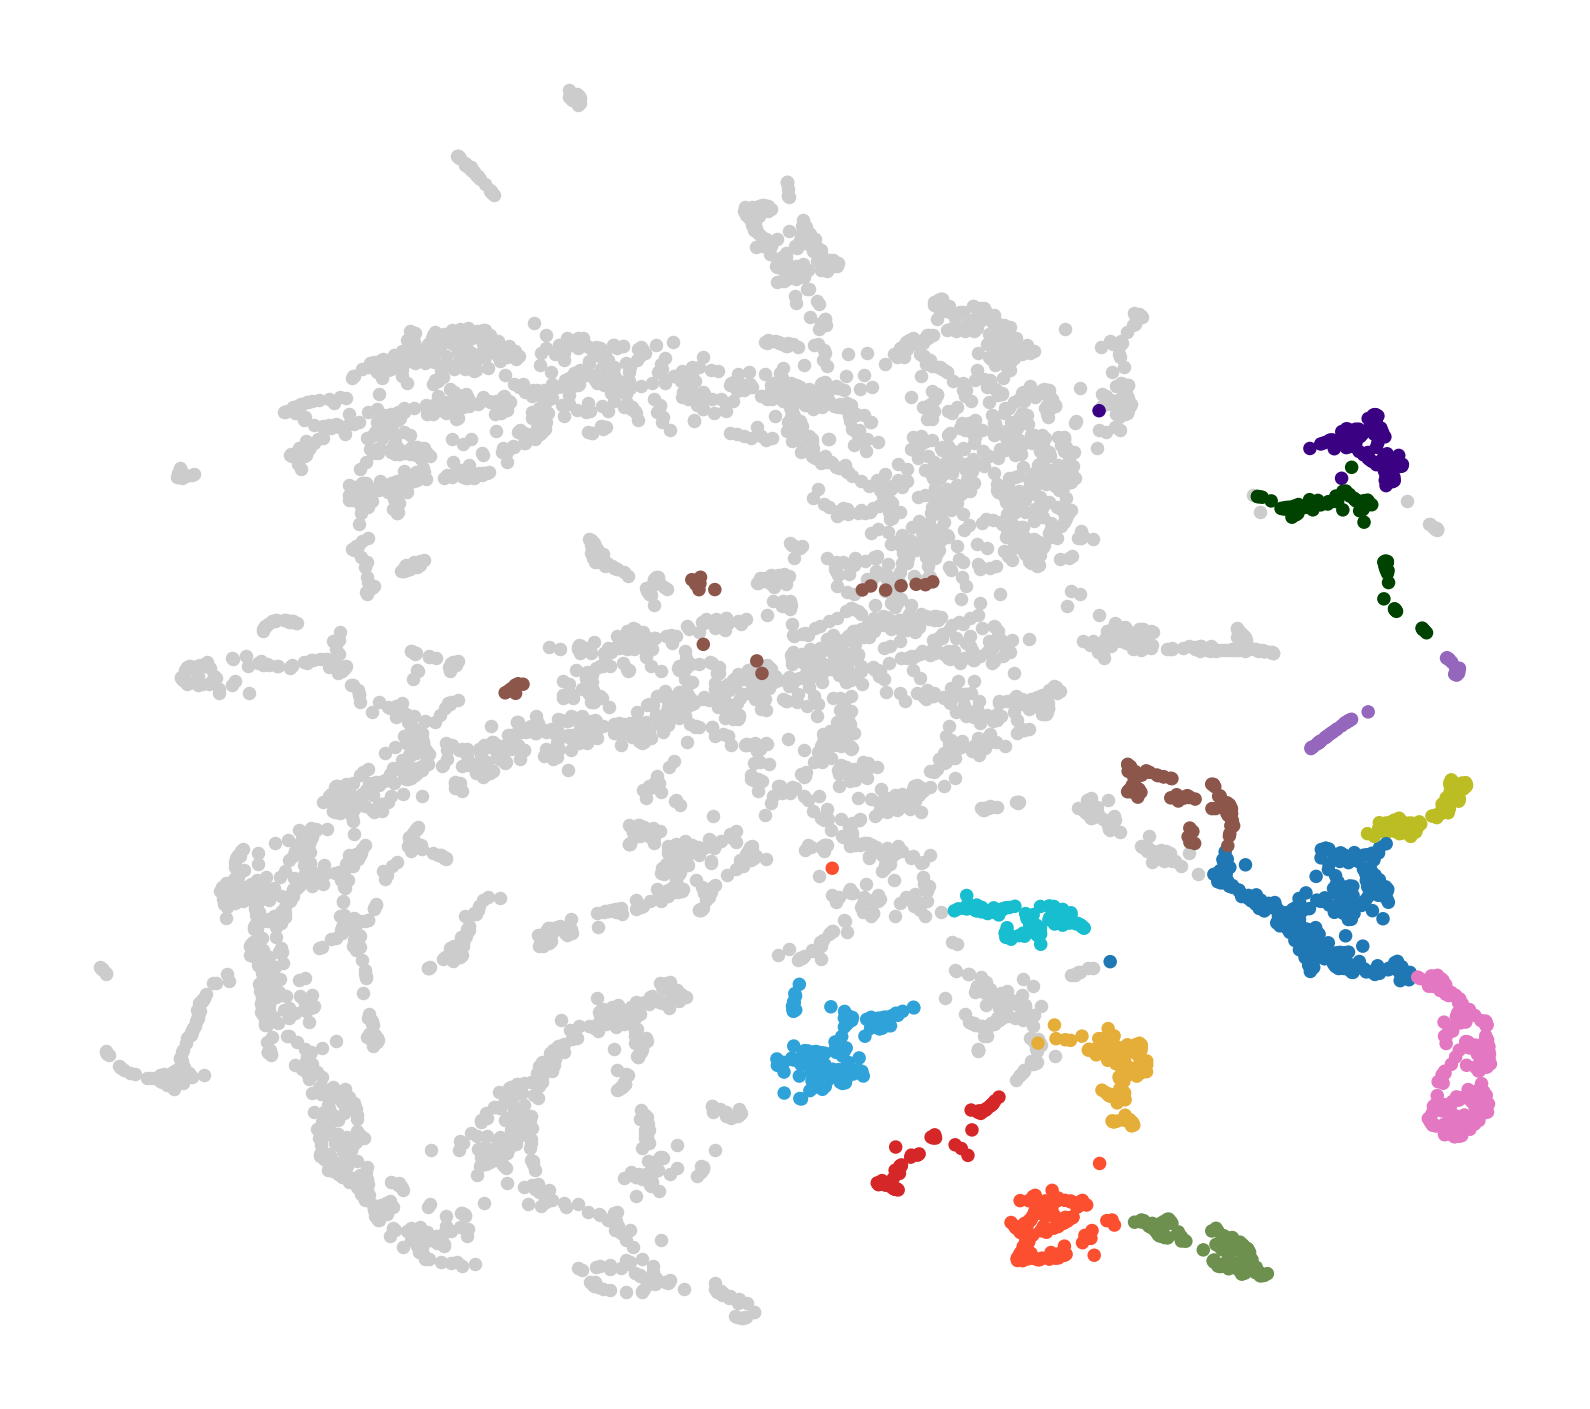

In [28]:
grey_mask = (umap_fig_df["Color"] == grey_rgb)
umap_background_fig_df = umap_fig_df[grey_mask]
umap_foreground_fig_df = umap_fig_df[~grey_mask]

fig = plt.figure(figsize=(5.4, 4.8))

plt.scatter(umap_background_fig_df["X Coord"],umap_background_fig_df["Y Coord"],c=grey_rgb,s=5,zorder=-1)
plt.scatter(umap_foreground_fig_df["X Coord"],umap_foreground_fig_df["Y Coord"],c=umap_foreground_fig_df["Color"],s=5,zorder=1)

sns.despine(left=True,bottom=True)
plt.xlabel("")
plt.ylabel("")
plt.xticks([])
plt.yticks([])
plt.title("",fontsize=20)
plt.tight_layout()
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Figure_5/Highlighted_UMAP.png",dpi=300,\
            transparent=True,bbox_inches = "tight")

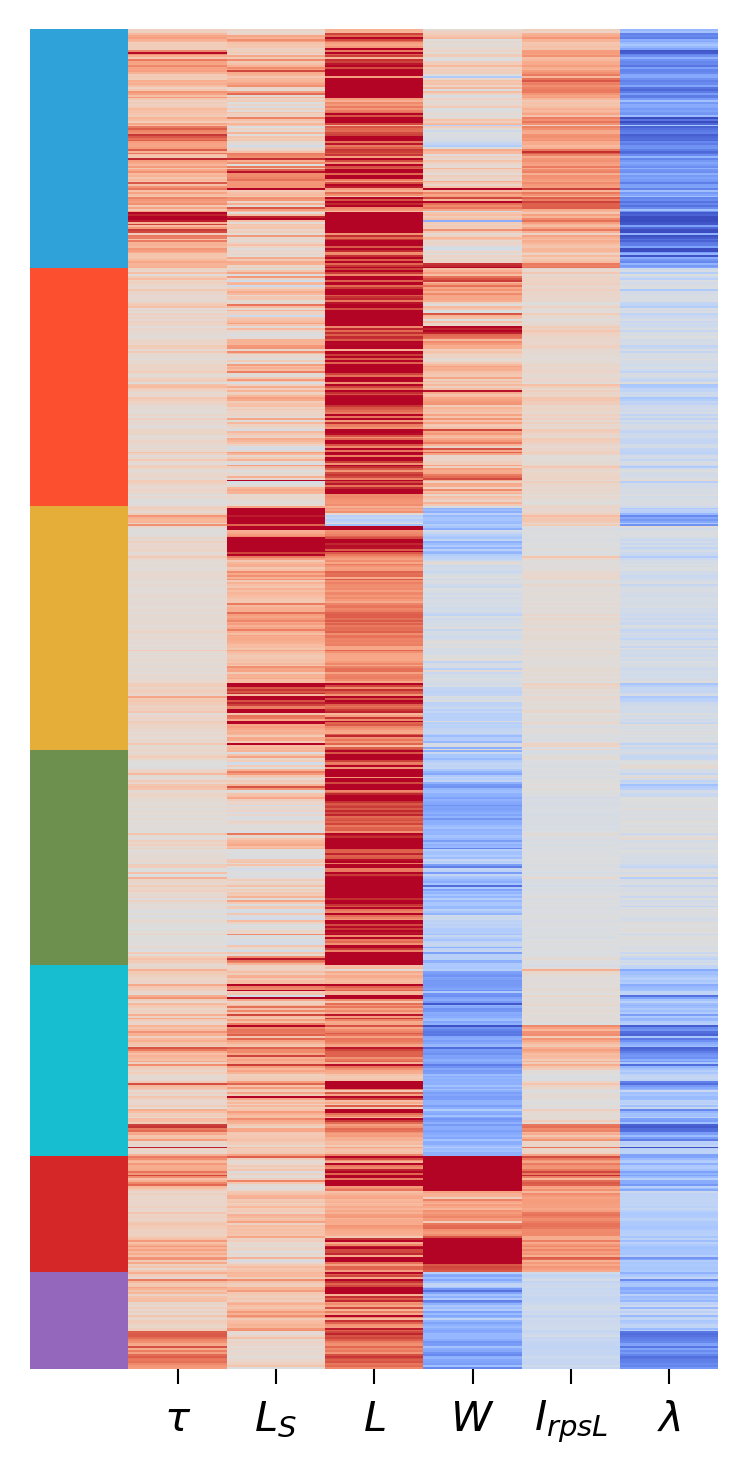

In [29]:
selected_cluster_df_clustersorted = selected_cluster_df.sort_values(["Priority Subcluster","Gene"])
selected_cluster_df_clustersorted = selected_cluster_df_clustersorted[["Gene","Gene (Merged Operons)","Priority Subcluster"] + all_labels]

selected_cluster_df_clustersorted_filamentous = selected_cluster_df_clustersorted[selected_cluster_df_clustersorted["Priority Subcluster"].\
                                apply(lambda x: x in filament_highlighted_subclusters)]

# Create a custom layout for the plots
n_entries = len(selected_cluster_df_clustersorted_filamentous)
fig = plt.figure(figsize=(3.25,(n_entries*0.007)))
gs = gridspec.GridSpec(1, len(all_labels)+1, width_ratios=[1, 1, 1, 1, 1, 1, 1, 1 ,1],hspace=0,wspace=0)
for i, label in enumerate(labels):
    ax = plt.subplot(gs[i+1])
    sns.heatmap(selected_cluster_df_clustersorted_filamentous[all_labels[i]].values.reshape(-1,1),vmin=min_vals[i],vmax=max_vals[i],\
                    cmap="coolwarm",center=median_vals_dict[label],\
                   cbar=False, yticklabels=False, ax=ax,annot=False,\
                   linewidths=0,linecolor="black")

    ax.set_xticklabels(labels=[label_names[i]],fontsize=10)
    
ax = plt.subplot(gs[0])
# Create separate single-column heatmaps for each column
cluster_1_arr = selected_cluster_df_clustersorted_filamentous["Priority Subcluster"].apply(lambda x: reorder_cluster_dict[x]).values.reshape(-1,1)

sns.heatmap(cluster_1_arr,cmap=cluster_cmap,norm=cluster_norm,cbar=False,yticklabels=[],\
            xticklabels=False, ax=ax, annot=False,linewidths=0,linecolor="black", annot_kws={"fontsize":14})
ax.tick_params(right=False, labelright=False, labelleft=True, labelrotation=0, size=0)
ax.set_yticklabels(ax.get_yticklabels(),fontdict={"fontsize":12})

## adjust nucleoid columns to the right
for i in range(len(labels)):
    ax = plt.subplot(gs[i+1])
    if i > 5:
        box = ax.get_position()
        box.x0 = box.x0 + 0.02
        box.x1 = box.x1 + 0.02
        ax.set_position(box)

plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Figure_5/All_sgRNA_Filament_Clusters.png",\
            dpi=300,transparent=True,bbox_inches = "tight")

/home/de64/micromamba/envs/crispri/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.draw()
/home/de64/micromamba/envs/crispri/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.draw()
/home/de64/micromamba/envs/crispri/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.draw()
/home/de64/micromamba/envs/crispri/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.draw()
/home/de64/micromamba/envs/crispri/lib/python3.11/site-p

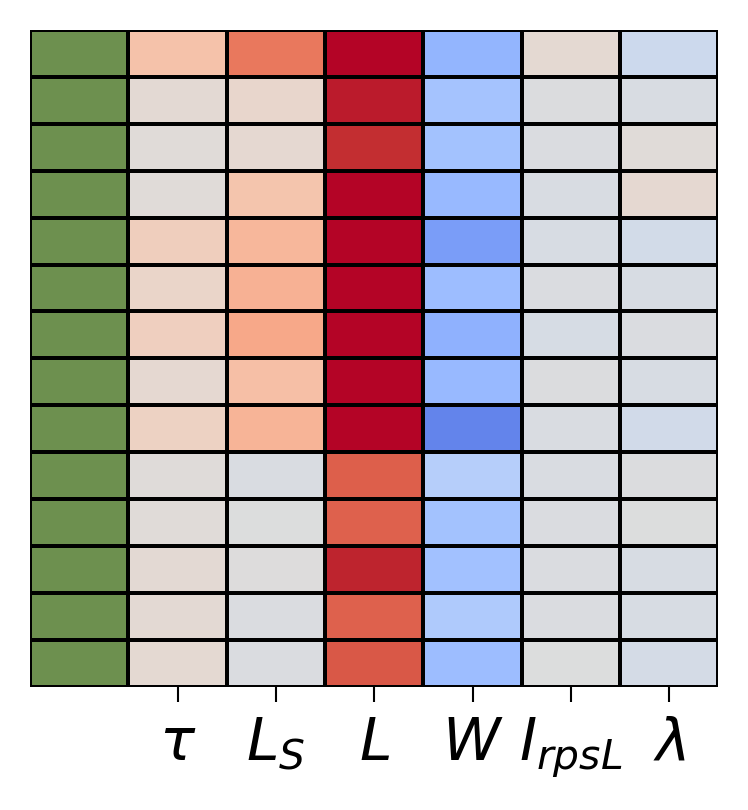

/home/de64/micromamba/envs/crispri/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


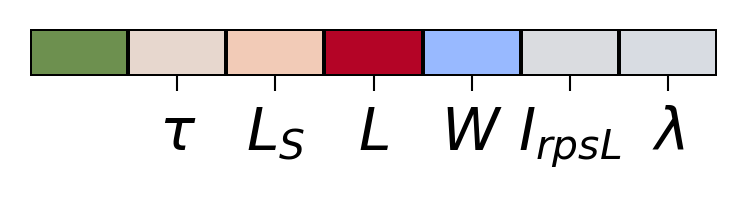

In [30]:
### sgRNA-cluster heatmap
gene_name = "ftsN"

select_gene_df = selected_cluster_df[selected_cluster_df["Gene"] == "ftsN"]
select_gene_df_clustersorted = select_gene_df.sort_values(["Priority Subcluster","Gene"])
select_gene_df_clustersorted = select_gene_df_clustersorted[["Gene","Gene (Merged Operons)","Priority Subcluster"] + all_labels]

select_gene_df_clustersorted_filamentous = select_gene_df_clustersorted[select_gene_df_clustersorted["Priority Subcluster"].\
                                apply(lambda x: x in filament_highlighted_subclusters)]

# Create a custom layout for the plots
n_entries = len(select_gene_df_clustersorted_filamentous)
fig = plt.figure(figsize=(3.25,(n_entries*0.2)))
gs = gridspec.GridSpec(1, len(all_labels)+1, width_ratios=[1, 1, 1, 1, 1, 1, 1, 1 ,1],hspace=0,wspace=0)
for i, label in enumerate(labels):
    ax = plt.subplot(gs[i+1])
    sns.heatmap(select_gene_df_clustersorted_filamentous[all_labels[i]].values.reshape(-1,1),vmin=min_vals[i],vmax=max_vals[i],\
                    cmap="coolwarm",center=median_vals_dict[label],\
                   cbar=False, yticklabels=False, ax=ax,annot=False,\
                   linewidths=0.5,linecolor="black")

    ax.set_xticklabels(labels=[label_names[i]],fontsize=14)
    
ax = plt.subplot(gs[0])
# Create separate single-column heatmaps for each column
cluster_1_arr = select_gene_df_clustersorted_filamentous["Priority Subcluster"].apply(lambda x: reorder_cluster_dict[x]).values.reshape(-1,1)

sns.heatmap(cluster_1_arr,cmap=cluster_cmap,norm=cluster_norm,cbar=False,yticklabels=[],\
            xticklabels=False, ax=ax, annot=False,linewidths=0.5,linecolor="black", annot_kws={"fontsize":14})
ax.tick_params(right=False, labelright=False, labelleft=True, labelrotation=0, size=0)
ax.set_yticklabels(ax.get_yticklabels(),fontdict={"fontsize":12})

# Remove margins between subplots
plt.subplots_adjust(wspace=0)
## adjust nucleoid columns to the right
for i in range(len(labels)):
    ax = plt.subplot(gs[i+1])
    if i > 5:
        box = ax.get_position()
        box.x0 = box.x0 + 0.02
        box.x1 = box.x1 + 0.02
        ax.set_position(box)

plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Figure_5/ftsN_sgrnas.png",\
            dpi=300,transparent=True,bbox_inches = "tight")

selected_gene_mean_series = gene_mean_df.loc[gene_name]

# Create a custom layout for the plots
n_entries = 1
fig = plt.figure(figsize=(3.8,(n_entries*0.2)))
gs = gridspec.GridSpec(1, len(all_labels)+1, width_ratios=[1, 1, 1, 1, 1, 1, 1, 1 ,1],hspace=0,wspace=0)
for i, label in enumerate(labels):
    ax = plt.subplot(gs[i+1])
    sns.heatmap(np.array(selected_gene_mean_series[all_labels[i]]).reshape(-1,1),vmin=min_vals[i],vmax=max_vals[i],\
                    cmap="coolwarm",center=median_vals_dict[label],\
                   cbar=False, yticklabels=False, ax=ax,annot=False,\
                   linewidths=0.5,linecolor="black")

    ax.set_xticklabels(labels=[label_names[i]],fontsize=14)
    
ax = plt.subplot(gs[0])
# Create separate single-column heatmaps for each column
cluster_1_arr = np.array(reorder_cluster_dict[selected_gene_mean_series["Cluster Assignment"][0]]).reshape(-1,1)

sns.heatmap(cluster_1_arr,cmap=cluster_cmap,norm=cluster_norm,cbar=False,yticklabels=[],\
            xticklabels=False, ax=ax, annot=False,linewidths=0.5,linecolor="black", annot_kws={"fontsize":14})
ax.tick_params(right=False, labelright=False, labelleft=True, labelrotation=0, size=0)
ax.set_yticklabels(ax.get_yticklabels(),fontdict={"fontsize":12})

# Remove margins between subplots
plt.subplots_adjust(wspace=0)
## adjust nucleoid columns to the right
for i in range(len(labels)):
    ax = plt.subplot(gs[i+1])
    if i > 5:
        box = ax.get_position()
        box.x0 = box.x0 + 0.02
        box.x1 = box.x1 + 0.02
        ax.set_position(box)

plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Figure_5/ftsN_mean.png",\
            dpi=300,transparent=True,bbox_inches = "tight")

## Figure 5E

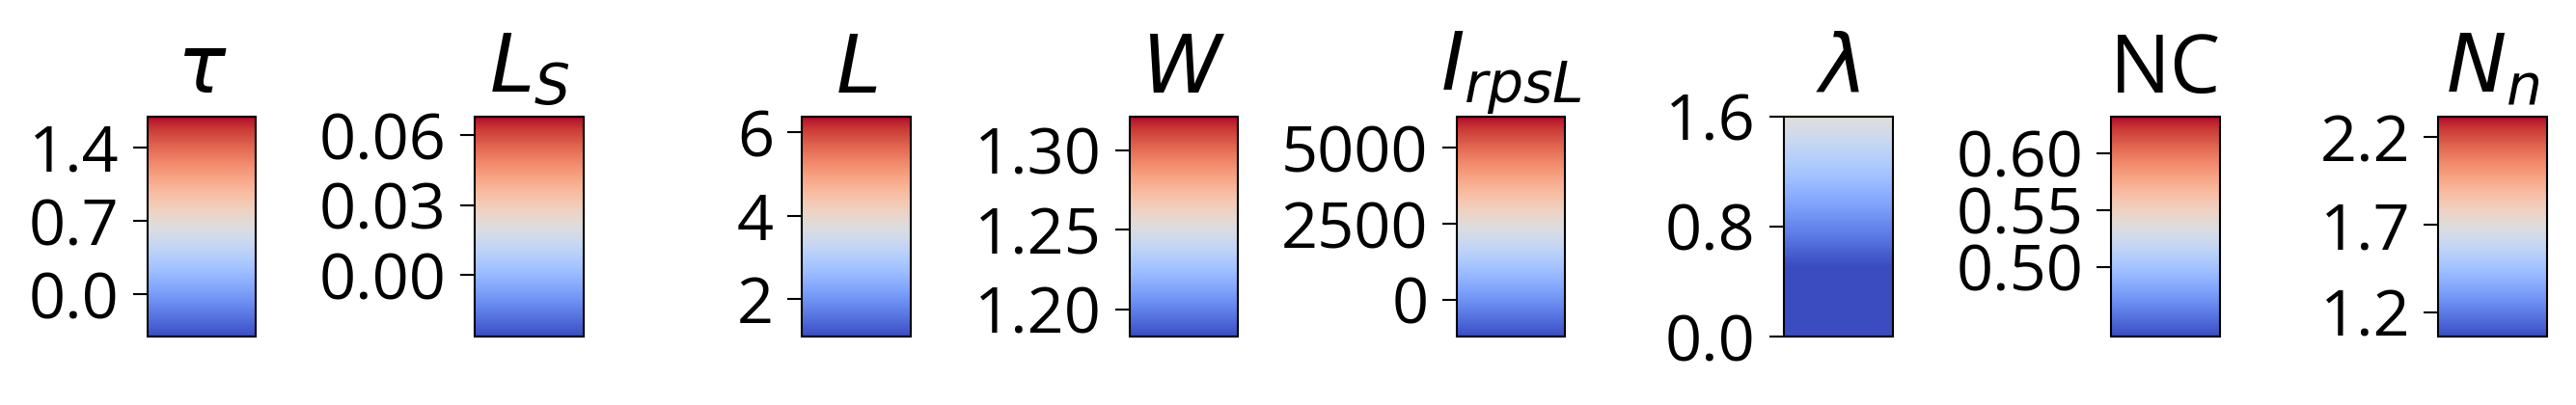

In [31]:
fig, axes = plt.subplots(1, len(all_labels)//1, figsize=(9, 1.5))
for i,label in enumerate(all_labels):
    cbar_ticks = cbar_ticks_list[i]
    # Create a colormap and a normalization object
    cmap = plt.get_cmap('coolwarm')  # or any other colormap, e.g., 'jet', 'coolwarm', 'plasma', etc.
    norm = mpl.colors.Normalize(vmin=min_vals[i], vmax=max_vals[i])  # set the range of values to normalize, e.g., 0 to 1

    # Create a ScalarMappable object
    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # this line is needed to create the ScalarMappable object, but the array can be empty

    if label == '8 Hours: Kernel Trace: Instantaneous Growth Rate: Volume':
        # Define the boundaries for the colorbar display range (e.g., only from 20 to 80)
        cbar_boundaries = np.linspace(cbar_ticks[0], cbar_ticks[-1], 100)  # Display only values between 20 and 80
        cbar = plt.colorbar(sm, cax=axes[i], orientation='vertical',ticks=cbar_ticks,boundaries=cbar_boundaries)
    else:
        cbar = plt.colorbar(sm, cax=axes[i], orientation='vertical',ticks=cbar_ticks)
    
    axes[i].set_title(label_names[i],fontsize=20)
    cbar.ax.tick_params(labelsize=16)
    axes[i].yaxis.set_ticks_position('left')
    # axes[i//2,i%2].set_yticklabels(axes[i//2,i%2].get_yticklabels(),fontsize=0)
plt.subplots_adjust(wspace=2)

# fig.delaxes(axes[-1,-1])
# Show the colorbar
plt.tight_layout()
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Figure_5/Global_Clusters_Scaling.png",dpi=300,transparent=True)